
---


**Projet Dapyness - Estimation de ventes e-commerce** 


---

*L’objectif de ce projet est d’estimer l’évolution du volume de vente de produits vendus en ligne par un site e-commerce en utilisant les données de ces ventes.*

*Pour cela, nous étudions une table de données que nous nommons **df** lors de l'importation.*



*   Nous commençons notre étude par importer, analyser et nettoyer notre jeu de données. 
*   Ensuite, nous créons de nouvelles variables jugées utiles pour la suite de notre étude.
*   Nous analysons ensuite graphiquement nos données.
*   Et enfin, nous procédons à la modélisation de nos données pour espérer obtenir de bonnes prévisions de ventes.






# **Préparation du Dataset et premières informations**

In [ ]:
# Cellule d'imporation des packages nécessaires aux codes

#packages basiques
import pandas as pd
import numpy as np

#partie graphique
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from bokeh.plotting import figure, output_notebook, show
output_notebook()

#tests statistiques
import statsmodels.api 
from scipy.stats import pearsonr

#modélisation
#régression
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

#modèles arima et sarima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [ ]:
# Lecture du fichier .csv correspondant à notre dataset et le stocker dans notre dataframe df
df = pd.read_csv('data.csv',encoding = "ISO-8859-1")

In [ ]:
#Importation du fichier csv chez Sanae 
#df=pd.read_csv('data-estimation.csv', sep=';')

In [ ]:
#Affichage des premières lignes de df
df.head()

In [ ]:
#Informations sur notre dataset
df.info()

In [ ]:
''' Nous avons 541909 lignes dans notre dataset, 8 colonnes, de type object, float ou int
Il semble également y avoir des valeurs manquantes dans les colonnes 'Description' et 'CustomerID' '''

In [ ]:
# description des variables quantitatives
df.describe()

In [ ]:
""" 
--> La colonne Quantity contient des valeurs très élevés et très basses,
 50% des valeurs sont comprises entre 1 et 10
--> La colonne UnitPrice contient également des valeurs très élevés et très basses
50% des valeurs sont comprises entre 1.25 et 4.13
Remarque : Nous ne comptons pas CustomerID comme étant une variable quantitative 
           car représente un identifiant client
"""

# **Etude et Gestion des doublons**

In [ ]:
# Détection des doublons
df.duplicated().sum()
# 5268 doublons

5268

In [ ]:
df[df.duplicated()]
# --> ne semblent pas correspondre à de réels doublons

In [ ]:
#affichage de tous les articles de la commande '536412
pd.set_option('display.max_rows', None)
df[df.InvoiceNo.isin(['536412'])]

In [ ]:
"""
 Nous emmetons l'hyptohèse d'absence de doublons. 
En effet, la plupart des lignes semblent ne pas réelment correspondre à des doublons.
De plus, un article peut très bien être entré plusieurs fois dans un panier,
ce qui peut expliquer les quelques doublons.
--> Nous ne supprimons pas ces lignes

"""

# **Etude approfondie des différentes colonnes**

In [ ]:
# calcul du nombre de valeurs uniques pour chaque colonnes
print('nombre de factures différentes : ', np.count_nonzero(df['InvoiceNo'].unique()))
print('nombre de code de stock différentes : ', np.count_nonzero(df['StockCode'].unique()))
print('nombre de descriptions différentes : ', np.count_nonzero(df['Description'].unique()))
print('nombre de valeurs de quantités différentes : ', np.count_nonzero(df['Quantity'].unique()))
print('nombre de valeurs de prix différentes : ', np.count_nonzero(df['UnitPrice'].unique()))
print('nombre de clients différents : ', np.count_nonzero(df['CustomerID'].unique()))
print('nombre de pays différents : ', np.count_nonzero(df['Country'].unique()))

nombre de factures différentes :  25900
nombre de code de stock différentes :  4070
nombre de descriptions différentes :  4224
nombre de valeurs de quantités différentes :  722
nombre de valeurs de prix différentes :  1629
nombre de clients différents :  4373
nombre de pays différents :  38


---
**Etude de la colonne InvoiceNo**


---

In [ ]:
# nous remarquons que les factures peuvent contenir des lettres en premiere position
# affichage des factures qui contiennent lettre C
df[df['InvoiceNo'].str.contains("C")].head()
#--> correspondent à des retours

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/01/2010 09:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/01/2010 09:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/01/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/01/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/01/2010 10:24,0.29,17548.0,United Kingdom


In [ ]:
#création d'une table avec uniquement les données pour lesquels la facture commence par la lettre C
data_invoice_C=df[df['InvoiceNo'].str.contains("C")]
# a-t-on des quantités positives dans ce cas ? 
data_invoice_C[data_invoice_C['Quantity'] >0]
# ==> non 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [ ]:
#affichage des factures qui contiennent lettre A
df[df['InvoiceNo'].str.contains("A")]
#--> correspondent à des ajustements de dettes 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,08/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,08/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,08/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
# essai avec toutes les lettres
df[df['InvoiceNo'].str.contains("Z")]
# --> Nous avons uniquement des factures composées de la lettre 'A' ou 'C' ou sans lettres

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


---
**Etude de la colonne UnitPrice**


---

In [ ]:
# Combien as-t-on de prix = 0 ?
df[df['UnitPrice']==0].UnitPrice.count()

2515

In [ ]:
# Combien as-t-on de prix < 0 ?
print('nombre de prix négatifs : ', df[df['UnitPrice']<0].UnitPrice.count())
df[df['UnitPrice'] < 0]
# --> 2 prix négatifs --> lignes correspondant à des ajustements de dettes

nombre de prix négatifs :  2


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,08/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,08/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
#ordre décroissant du prix
df.sort_values(by='UnitPrice', ascending=False).head(10)
#--> Nous retrouvons des prix très élevés.
## nous remarquons des données innatendues dans 'Description' et 'StockCode'
# --> Pour ces prix, le stockcode ainsi que la description ne 
# correspondent pas à des articles mais plutôt des autres opérations
# nous verrons cela en détails dans la prochaine partie sur l'étude de la colonne StockCode

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
222681,C556445,M,Manual,-1,06/10/2011 15:31,38970.00,15098.0,United Kingdom
524602,C580605,AMAZONFEE,AMAZON FEE,-1,12/05/2011 11:36,17836.46,NaN,United Kingdom
43702,C540117,AMAZONFEE,AMAZON FEE,-1,01/05/2011 09:55,16888.02,NaN,United Kingdom
43703,C540118,AMAZONFEE,AMAZON FEE,-1,01/05/2011 09:57,16453.71,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/07/2010 15:08,13541.33,NaN,United Kingdom
16356,C537651,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:49,13541.33,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:04,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:34,13474.79,NaN,United Kingdom
524601,C580604,AMAZONFEE,AMAZON FEE,-1,12/05/2011 11:35,11586.50,NaN,United Kingdom
299982,A563185,B,Adjust bad debt,1,08/12/2011 14:50,11062.06,NaN,United Kingdom


---
**Etude de la colonne StockCode**


---

In [ ]:
#affichage des différents stockcode lorsque le prix > 100 (--> pour détecter les anomalies)
df[df['UnitPrice'] > 100].StockCode.unique()

array(['22827', 'DOT', '22655', 'M', 'D', 'AMAZONFEE', '22828', '22826',
       '22656', 'BANK CHARGES', '22823', 'C2', 'S', 'POST', '22502', 'B',
       'CRUK'], dtype=object)

In [ ]:
#essai avec toutes les lettres de l'alphabet pour détecter des codes anormaux
df[df['StockCode'].str.contains("Z")].StockCode.unique()

array(['AMAZONFEE', '90214Z'], dtype=object)

In [ ]:
#affichage des lignes pour lesquelles stockcode == C2
print('nombre de prix différents dans le cas de frais de transport : ', df[df['StockCode'] == 'C2'].UnitPrice.unique())
df[df['StockCode'] == 'C2'].head(5)
# --> frais de transport 

nombre de prix différents dans le cas de frais de transport :  [ 50. 150.  15.  18.  25.   0.]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1423,536540,C2,CARRIAGE,1,12/01/2010 14:05,50.0,14911.0,EIRE
12119,537368,C2,CARRIAGE,1,12/06/2010 12:40,50.0,14911.0,EIRE
12452,537378,C2,CARRIAGE,1,12/06/2010 13:06,50.0,14911.0,EIRE
19975,537963,C2,CARRIAGE,1,12/09/2010 11:30,50.0,13369.0,United Kingdom
20016,538002,C2,CARRIAGE,1,12/09/2010 11:48,50.0,14932.0,Channel Islands


In [ ]:
#affichage des lignes pour lesquelles stockcode == D
df[df['StockCode'] == 'D'].head(5)
# --> correspondent à des remises

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/01/2010 09:41,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,12/05/2010 13:21,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,12/07/2010 12:34,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,12/08/2010 16:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,12/15/2010 9:14,5.76,16422.0,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == S
df[df['StockCode'] == 'S'].head()
#--> correspondent à des échantillon

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14436,C537581,S,SAMPLES,-1,12/07/2010 12:03,12.95,NaN,United Kingdom
14437,C537581,S,SAMPLES,-1,12/07/2010 12:03,52.00,NaN,United Kingdom
96680,C544580,S,SAMPLES,-1,2/21/2011 14:25,5.74,NaN,United Kingdom
96681,C544580,S,SAMPLES,-1,2/21/2011 14:25,11.08,NaN,United Kingdom
96682,C544580,S,SAMPLES,-1,2/21/2011 14:25,5.79,NaN,United Kingdom


In [ ]:
df[df['StockCode'] == 'S'].CustomerID.unique()
#--> on a uniquement des NaN pour customerID

array([nan])

In [ ]:
#affichage des lignes pour lesquelles stockcode == B
df[df['StockCode'] == 'B']
#--> ajustement dettes

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299982,A563185,B,Adjust bad debt,1,08/12/2011 14:50,11062.06,NaN,United Kingdom
299983,A563186,B,Adjust bad debt,1,08/12/2011 14:51,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,08/12/2011 14:52,-11062.06,NaN,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == M
df[df['StockCode'] == 'M'].head()
# --> correspondent à des commandse entrées manuellement 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2239,536569,M,Manual,1,12/01/2010 15:35,1.25,16274.0,United Kingdom
2250,536569,M,Manual,1,12/01/2010 15:35,18.95,16274.0,United Kingdom
5684,536865,M,Manual,1,12/03/2010 11:28,2.55,NaN,United Kingdom
6798,536981,M,Manual,2,12/03/2010 14:26,0.85,14723.0,United Kingdom
7976,537077,M,Manual,12,12/05/2010 11:59,0.42,17062.0,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == 'BANK CHARGES'
df[df['StockCode'] == 'BANK CHARGES'].head()
# --> correspondent à des frais de banque 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
4406,536779,BANK CHARGES,Bank Charges,1,12/02/2010 15:08,15.00,15823.0,United Kingdom
14435,C537572,BANK CHARGES,Bank Charges,-1,12/07/2010 12:00,95.38,NaN,United Kingdom
28992,C538680,BANK CHARGES,Bank Charges,-1,12/13/2010 17:10,966.92,NaN,United Kingdom
62508,541505,BANK CHARGES,Bank Charges,1,1/18/2011 15:58,15.00,15939.0,United Kingdom
64573,C541653,BANK CHARGES,Bank Charges,-1,1/20/2011 11:50,1050.15,NaN,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == 'AMAZON FEE'
df[df['Description'] == 'AMAZON FEE'].head()
# on a que des Nan pour customerID

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
14514,C537600,AMAZONFEE,AMAZON FEE,-1,12/07/2010 12:41,1.00,NaN,United Kingdom
15016,C537630,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:04,13541.33,NaN,United Kingdom
15017,537632,AMAZONFEE,AMAZON FEE,1,12/07/2010 15:08,13541.33,NaN,United Kingdom
16232,C537644,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:34,13474.79,NaN,United Kingdom
16313,C537647,AMAZONFEE,AMAZON FEE,-1,12/07/2010 15:41,5519.25,NaN,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == 'POST'
df[df['StockCode'] == 'POST'].head()
#--> correspondent à des frais de postage

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
45,536370,POST,POSTAGE,3,12/01/2010 08:45,18.0,12583.0,France
386,536403,POST,POSTAGE,1,12/01/2010 11:27,15.0,12791.0,Netherlands
1123,536527,POST,POSTAGE,1,12/01/2010 13:04,18.0,12662.0,Germany
5073,536840,POST,POSTAGE,1,12/02/2010 18:27,18.0,12738.0,Germany
5258,536852,POST,POSTAGE,1,12/03/2010 09:51,18.0,12686.0,France


In [ ]:
#affichage des lignes pour lesquelles stockcode == 'DOT'
df[df['StockCode'] == 'DOT'].head()
# --> également des frais de postage
# --> ne concerne qu'un client ou clients non identifiés

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1814,536544,DOT,DOTCOM POSTAGE,1,12/01/2010 14:32,569.77,NaN,United Kingdom
3041,536592,DOT,DOTCOM POSTAGE,1,12/01/2010 17:06,607.49,NaN,United Kingdom
5450,536862,DOT,DOTCOM POSTAGE,1,12/03/2010 11:13,254.43,NaN,United Kingdom
5545,536864,DOT,DOTCOM POSTAGE,1,12/03/2010 11:27,121.06,NaN,United Kingdom
5685,536865,DOT,DOTCOM POSTAGE,1,12/03/2010 11:28,498.47,NaN,United Kingdom


In [ ]:
#affichage des lignes pour lesquelles stockcode == CRUK
df[df['StockCode'] == 'CRUK'].head()
#--> commission, ne concerne qu'un client

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
317508,C564763,CRUK,CRUK Commission,-1,8/30/2011 10:49,1.60,14096.0,United Kingdom
324023,C565382,CRUK,CRUK Commission,-1,09/02/2011 15:45,13.01,14096.0,United Kingdom
333779,C566216,CRUK,CRUK Commission,-1,09/09/2011 15:17,15.96,14096.0,United Kingdom
338848,C566565,CRUK,CRUK Commission,-1,9/13/2011 12:32,52.24,14096.0,United Kingdom
351003,C567655,CRUK,CRUK Commission,-1,9/21/2011 14:40,608.66,14096.0,United Kingdom


---
**Etude de la colonne Country**


---

In [ ]:
#affichage des différents pays présents dans le dataset
df['Country'].unique()
#38 pays différents

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

In [ ]:
# Part d'articles différents vendus par pays
df['Country'].value_counts(normalize = True)
# --> 91,4% des articles vendus à UK
#le reste des pays comptabilisent moins de 2% des commandes
# --> données non équilibrées

United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

---
**Etude de la colonne Quantity**


---

In [ ]:
# calcul du nombre de fois où l'on a des quantités négatives/postives/nulles
print('Nombre de quantités négatives : ', df[df['Quantity']<0].Quantity.count())
print('Nombre de quantités positives : ', df[df['Quantity']>0].Quantity.count())
print('Nombre de quantités nulles : ', df[df['Quantity']==0].Quantity.count())

Nombre de quantités négatives :  10624
Nombre de quantités positives :  531285
Nombre de quantités nulles :  0


In [ ]:
#ordre décroissant de la quantité
df.sort_values(by='Quantity', ascending=False).head()
# --> Nous avons des quantités très élevées et très basses en négatif
# mais cela peut s'expliquer par le fait que la majorité des clients soient des grossistes
# valeurs non abérrantes

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/09/2011 09:15,2.08,16446.0,United Kingdom
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,11/25/2011 15:57,0.00,13256.0,United Kingdom
74614,542504,37413,NaN,5568,1/28/2011 12:03,0.00,NaN,United Kingdom
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,10/27/2011 12:26,0.21,12901.0,United Kingdom


In [ ]:
''' En résumé : 

--> Nous avons 3 types de factures différentes : 
    - Les factures 'A' --> ajustements de dettes
    - les factures 'C' --> principalement des annulations de commandes (peut contenir d'autres types de 
    lignes comme des frais) 
    - les factures non lettrées --> principalement des ventes (peut contenir d'autres types de lignes 
    commes frais, transport, frais bancaire...)

--> Nous avons des stockcode qui ne correspondent pas à des produits mais font références à d'autres "opérations" 
comme les frais, transport, postage...
    ==> Dans la suite, nous créerons une nouvelle colonne 'InvoiceType' dans laquelle nous catégoriserons les lignes 
    selon leur type : vente, annulations, dettes, frais, échantillons, ... (voir section création de nouvelles colonnes)

--> Des quantités très élevées et très basses --> valeurs non abérrantes car présence de grossistes 
dans notre base de données. 

--> Des prix très élevés --> lignes non correspondant à des articles mais plutôt des 'opérations' (frais, postage, etc...)
--> 2 prix négatifs --> ajustement de dettes 
--> Des prix nuls --> (étudiés dans la section 'Etude et gestion des valeurs manquantes') 
    correspondent soit à des problèmes de commandes soit des 'cadeaux' ou 'offres'

--> 38 pays différents dont un surreprésenté : UK    

--> Les colonnes 'Description' et 'CustomerID' sont étudiées dans la section suivante 
(Etude et gestion des valeurs manquantes) '''

# **Etude et gestion des valeurs manquantes**





---


**Commentaires**



---

In [ ]:
"""
A propos des NaNs, nous réflechissons à 2 possibilités : 

Première possibilité : Suppression des NaN
data_clean = data.dropna(axis=0, how = 'any', subset =['Description','CustomerID'])

Deuxième possibilité : 
  a) Conservation des NaNs de la colonne 'Description' et les remplacer par une nouvelle valeur. Par exemple : "Non identifié" 
  b) Conservation des NaNs de la colonne 'CustomerID' et créer un nouvel identifiant client (soit le même pour tous les NaNs, soit un différent pour chaque NaNs)  
"""

In [ ]:
# détection des colonnes avec au moins une valeur manquante 
df.isna().any(axis=0)
# --> les colonnes description et customerID contienent des valeurs manquantes

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [ ]:
# calcul du nombre de valeurs manquantes pour chaque colonne
df.isnull().sum(axis=0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [ ]:
# Affichage des lignes qui ont au moins une valeur manquante 
df[df.isna().any(axis=1)]

## *Etude des valeurs manquantes de la colonne Description*

In [ ]:
# Affichage des 20 premières entrées contenant un Na dans la colonne Description 
df[df[['Description' ]].isna().any(axis=1)].head(20)
# --> Remarque : lorsque la colonne description contient une valeur manquante, on a l'impression
# que la colonne customerID contient également une valeur manquante 
# --> On a aussi l'impression que le prix est égal à 0 
#hypothèse vérifiée lors du code suivant

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/01/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/01/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/01/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/01/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/01/2010 14:34,0.0,NaN,United Kingdom
1988,536550,85044,NaN,1,12/01/2010 14:34,0.0,NaN,United Kingdom
2024,536552,20950,NaN,1,12/01/2010 14:34,0.0,NaN,United Kingdom
2025,536553,37461,NaN,3,12/01/2010 14:35,0.0,NaN,United Kingdom
2026,536554,84670,NaN,23,12/01/2010 14:35,0.0,NaN,United Kingdom
2406,536589,21777,NaN,-10,12/01/2010 16:50,0.0,NaN,United Kingdom


In [ ]:
# code permettant de connaître les différentes valeurs de CustomerID lorsque la colonne Description contient une valeur manquante
df[df[['Description']].isna().any(axis=1)].CustomerID.unique()
# --> uniquement nan => lorsque la colonne description contient une valeur manquante, la colonne customerID également

array([nan])

In [ ]:
# code permettant de connaître les différentes valeurs de prix lorsque la colonne Description = NaN
df[df[['Description']].isna().any(axis=1)].UnitPrice.unique()
# --> prix = 0 pour toutes les fois où nous avons une description = Nan 

array([0.])

In [ ]:
# affichage des lignes lorsque Description = NaN, ordonnée par Quantity
df[df[['Description' ]].isna().any(axis=1)].sort_values(by='Quantity', ascending=True).head(10)
# Remarque : lorsque Description = NaN, et quantity < 0, InvoiceNo ne contient pas le caractère 'C' avant le numéro

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
341601,566768,16045,NaN,-3667,9/14/2011 17:53,0.0,NaN,United Kingdom
323458,565304,16259,NaN,-3167,09/02/2011 12:18,0.0,NaN,United Kingdom
270886,560600,18007,NaN,-2834,7/19/2011 17:04,0.0,NaN,United Kingdom
156350,550133,85099F,NaN,-1092,4/14/2011 13:49,0.0,NaN,United Kingdom
44863,540241,35957,NaN,-939,01/05/2011 15:17,0.0,NaN,United Kingdom
332823,566121,23306,NaN,-682,09/09/2011 10:56,0.0,NaN,United Kingdom
169680,551201,16015,NaN,-620,4/27/2011 11:33,0.0,NaN,United Kingdom
305607,563700,85106,NaN,-553,8/18/2011 13:55,0.0,NaN,United Kingdom
277041,561086,15036,NaN,-530,7/25/2011 9:32,0.0,NaN,United Kingdom
221960,556300,20735,NaN,-472,06/10/2011 10:18,0.0,NaN,United Kingdom


In [ ]:
# code permettant de connaître les différents pays pour lesquels nous avons une donnée manquante dans la col Description
df[df[['Description']].isna().any(axis=1)].Country.unique()
# --> donnée manquantes uniquement lorsque le pays est 'United Kingdom'

array(['United Kingdom'], dtype=object)

In [ ]:
"""
 En résumé : lorsque Description contient une valeur manquante :
--> on a égalament une valeur manquante dans colonne CustomerID
--> on a un prix nul
--> le seul pays présent est United Kingdom
--> lorsque quantity < 0, InvoiceNo non composé de la lettre 'C' : ne correpond pas à un retour 

==> Nous n'avons pas beaucoup d'informations sur ces données lorsque Description=NaN 
   ==> Nous décidons de supprimer ces données (1% de la table)
"""

## *Etude des valeurs manquantes de la colonnes CustomerID*

In [ ]:
#création d'une table avec les entrées pour lesquelles CustomerID = Nan
customers_nan = df[df[['CustomerID']].isna().any(axis=1)]

#suppression des lignes pour lesquelles description=Nan (car ce cas a été étudié plus haut)
customers_nan=customers_nan.dropna(axis=0,how='all', subset=['Description'])
customers_nan.head(10)

Etudions dans un premier temps cette table de clients non identifiés lorsque quantity < 0 

In [ ]:
#affichage de la table customers_nan lorsque la quantité est négative
customers_nan[customers_nan['Quantity']<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7313,537032,21275,?,-30,12/03/2010 16:50,0.00,NaN,United Kingdom
11502,C537251,22429,ENAMEL MEASURING JUG CREAM,-2,12/06/2010 10:45,4.25,NaN,United Kingdom
11503,C537251,22620,4 TRADITIONAL SPINNING TOPS,-8,12/06/2010 10:45,1.25,NaN,United Kingdom
11504,C537251,21890,S/6 WOODEN SKITTLES IN COTTON BAG,-2,12/06/2010 10:45,2.95,NaN,United Kingdom
11505,C537251,22564,ALPHABET STENCIL CRAFT,-5,12/06/2010 10:45,1.25,NaN,United Kingdom
11506,C537251,21891,TRADITIONAL WOODEN SKIPPING ROPE,-3,12/06/2010 10:45,1.25,NaN,United Kingdom
11507,C537251,22747,POPPY'S PLAYHOUSE BATHROOM,-6,12/06/2010 10:45,2.10,NaN,United Kingdom
11508,C537251,22454,MEASURING TAPE BABUSHKA RED,-8,12/06/2010 10:45,2.95,NaN,United Kingdom
11509,C537251,22327,ROUND SNACK BOXES SET OF 4 SKULLS,-4,12/06/2010 10:45,2.95,NaN,United Kingdom
11510,C537251,21915,RED HARMONICA IN BOX,-4,12/06/2010 10:45,1.25,NaN,United Kingdom


In [ ]:
''' Commentaire : 
Il semblerait qu'il y ait des 'problèmes de commandes'. Nous pouvons voir cela dans la colonne Description
où l'on peut trouver des valeurs comme : ?, lost, missing,... 
--> Pour ces commandes 'problèmes', la facture semble ne pas être composée de la lettre 'C',
 ce qui renforce notre hypothèse '''

In [ ]:
# affichage des clients NaN lorsque la facture ne contient pas la lettre 'C' et quantity est négatif
customers_nan[-(customers_nan['InvoiceNo'].str.contains("C")) & (customers_nan['Quantity']<0)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
7313,537032,21275,?,-30,12/03/2010 16:50,0.0,NaN,United Kingdom
13217,537425,84968F,check,-20,12/06/2010 15:35,0.0,NaN,United Kingdom
13218,537426,84968E,check,-35,12/06/2010 15:36,0.0,NaN,United Kingdom
13264,537432,35833G,damages,-43,12/06/2010 16:10,0.0,NaN,United Kingdom
21338,538072,22423,faulty,-13,12/09/2010 14:10,0.0,NaN,United Kingdom


In [ ]:
# affichage des différentes valeurs de prix lorsque client NaN, quantity < 0 et facture ne contient pas la lettre 'C'
customers_nan[-(customers_nan['InvoiceNo'].str.contains("C")) & (customers_nan['Quantity']<0)].UnitPrice.unique()
#--> Nous trouvons uniquement UnitPrice=0 

array([0.])

In [ ]:
#affichage des différentes descriptions lorsque clients NaN, facture ne contient pas 'C' et quantity <0
customers_nan[-(customers_nan['InvoiceNo'].str.contains("C")) & (customers_nan['Quantity']<0)].Description.unique()
#Nous ne trouvons aucun produit dans cette liste de descirptions mais uniquement des informations ressemblant
#à des problèmes de commandes
#--> Notre hypothèse est vérifiée --> lorsque quantity < 0 et facture ne contient pas la lettre 'C' 
#les lignes correspondent à des probèmes de commandes

array(['?', 'check', 'damages', 'faulty', 'Dotcom sales',
       'reverse 21/5/10 adjustment', 'mouldy, thrown away.', 'counted',
       'Given away', 'Dotcom', 'label mix up', 'samples/damages',
       'thrown away', 'incorrectly made-thrown away.', 'showroom', 'MIA',
       'Dotcom set', 'wrongly sold as sets', 'Amazon sold sets',
       'dotcom sold sets', 'wrongly sold sets', '? sold as sets?',
       '?sold as sets?', 'Thrown away.', 'damages/display',
       'damaged stock', 'broken', 'throw away', 'wrong barcode (22467)',
       'wrong barcode', 'barcode problem', '?lost',
       "thrown away-can't sell.", "thrown away-can't sell", 'damages?',
       're dotcom quick fix.', "Dotcom sold in 6's", 'sold in set?',
       'cracked', 'sold as 22467', 'Damaged',
       'mystery! Only ever imported 1800',
       'MERCHANT CHANDLER CREDIT ERROR, STO', 'POSSIBLE DAMAGES OR LOST?',
       'damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
       'wrong code', 'adjust', 'crushed', 

In [ ]:
# affichage des clients NaN lorsque la facture contient la lettre 'C'
customers_nan[customers_nan['InvoiceNo'].str.contains("C")]
# Dans ce cas, les lignes semblent correspondre à des retours de commandes. Il ne semble pas y avoir de problème de commande

In [ ]:
# affichage des différentes descriptions lorsque client=NaN et facture 'C'
customers_nan[customers_nan['InvoiceNo'].str.contains("C")].Description.unique()
# nous avons uniquement des descriptions d'articles normales dans le cas où la facture est composée de la lettre 'C'
# aucune descriptions 'problème' --> notre hypothèse est vérifiée

Etudions la table des clients NaN lorsque quantity > 0

In [ ]:
# affichage des clients Nan avec quantity > 0
customers_nan[customers_nan['Quantity']>0]
#--> semblent correspondre à des ventes

In [ ]:
#affichage des clients Nans lorsque prix =0 et quantity > 0 
customers_nan[(customers_nan['UnitPrice'] == 0) & (customers_nan['Quantity']>0)]
# --> il semblerait qu'on ait également quelques descriptions "problèmes" lorsque la quantity est > 0

In [ ]:
#les différentes descriptions lorsque prix=0 et quantity>0
customers_nan[(customers_nan['UnitPrice'] == 0) & (customers_nan['Quantity']>0)].Description.unique()
# il y a bien quelques descriptions problems

In [ ]:
# Créons une liste contenant toutes les descriptions 'problèmes' que nous avons pu rencontrer


Description_problems = ['?', 'check', 'damages', 'faulty', 'Dotcom sales','reverse 21/5/10 adjustment',
                        'mouldy, thrown away.', 'counted','Given away', 'Dotcom', 'label mix up', 'samples/damages',
                        'thrown away', 'incorrectly made-thrown away.', 'showroom', 'MIA','Dotcom set',
                        'wrongly sold as sets', 'Amazon sold sets', 'dotcom sold sets', 'wrongly sold sets', 
                        '? sold as sets?','?sold as sets?', 'Thrown away.', 'damages/display','damaged stock',
                        'broken', 'throw away', 'wrong barcode (22467)','wrong barcode', 'barcode problem', '?lost',
                        "thrown away-can't sell.", "thrown away-can't sell", 'damages?','re dotcom quick fix.', 
                        "Dotcom sold in 6's", 'sold in set?','cracked', 'sold as 22467', 'Damaged',
                        'mystery! Only ever imported 1800','MERCHANT CHANDLER CREDIT ERROR, STO',
                        'POSSIBLE DAMAGES OR LOST?','damaged', 'DAMAGED', 'Display', 'Missing', 'wrong code?',
                        'wrong code', 'adjust', 'crushed', 'damages/showroom etc','samples', 
                        'damages/credits from ASOS.','Not rcvd in 10/11/2010 delivery', 'Thrown away-rusty',
                        'sold as set/6 by dotcom', 'wet/rusty', 'damages/dotcom?','smashed',
                        'reverse previous adjustment', 'incorrectly credited C550456 see 47', 'wet damaged',
                        'Water damaged', 'missing', 'sold as set on dotcom','sold as set on dotcom and amazon', 
                        'water damage', 'sold as set by dotcom', 'Printing smudges/thrown away',
                        'printing smudges/thrown away', 'found some more on shelf','Show Samples', 
                        'mix up with c', 'mouldy, unsaleable.','wrongly marked. 23343 in box',
                        'stock creditted wrongly', 'ebay','incorrectly put back into stock', 'Damages/samples',
                        'Sold as 1 on dotcom', 'taig adjust no stock','code mix up? 84930', '?display?',
                        'sold as 1', '?missing','crushed ctn', 'Crushed', 'temp adjustment', '??', 'test',
                        'OOPS ! adjustment', 'Dagamed','historic computer difference?....se',
                        'Incorrect stock entry.','incorrect stock entry.', 'wrongly coded-23343', 'stock check',
                        'crushed boxes', 'WET/MOULDY', "can't find", 'mouldy','Wet pallet-thrown away',
                        'adjustment', '20713 wrongly marked','re-adjustment', 'Breakages', '20713', 
                        'wrongly coded 20713','Damages', 'CHECK', 'Unsaleable, destroyed.', 'dotcom sales',
                        'damages wax', 'water damaged', 'Wrongly mrked had 85123a in box',
                        'wrongly marked carton 22804', 'missing?', 'wet rusty', '???lost','sold with wrong barcode',
                        'rusty thrown away', 'rusty throw away','dotcom', '?? missing', 'wet pallet', 
                        '????missing', '???missing','lost in space', 'wet?', 'lost??', '???', 'wet', 'wet boxes',
                        '????damages????', 'mixed up', 'lost', 'amazon', 'amazon sales', 'Adjustment',
                        'wrongly sold (22719) barcode','rcvd be air temp fix for dotcom sit',
                        'did  a credit  and did not tick ret','adjustment', 'returned','mailout ', 
                        'mailout', 'on cargo order','incorrectly credited C550456 see 47',
                        'to push order througha s stock was ','FOUND', 'came coded as 20713',
                        'alan hodge cant mamage this section', 'dotcom', 'test', 'taig adjust',
                        'allocate stock for dotcom orders ta','add stock to allocate online orders',
                        'for online retail orders','Amazon', 'found box', 'damaged', 'Found in w/hse',
                        'website fixed', 'Lighthouse Trading zero invc incorr',
                        'michel oops', 'wrongly coded 20713', 'Had been put aside.',
                        'Sale error', 'Amazon Adjustment', 'wrongly marked 23343',
                        'Marked as 23343', 'wrongly coded 23343', 'Found by jackie',
                        'check', 'wrongly marked', 'had been put aside', 'amazon adjust',
                        'dotcomstock', 'John Lewis', 'dotcom adjust', 'check?']


In [ ]:
# Vérifions que ces descriptions problèmes ne concernent que les clients non identifiés (dans la table df)
df[df.Description.isin(Description_problems)].CustomerID.unique()
# --> uniquement client NaN donc hyptohèse vérifiée

array([nan])

In [ ]:
# Vérifions que lorsque l'on rencontre ces descriptions problèmes, le prix est nul (dans table df)
df[df.Description.isin(Description_problems)].UnitPrice.unique()
# --> uniquement prix =0

array([0.])

In [ ]:
# affichage des clients NaN lorsque le prix = 0
customers_nan[customers_nan['UnitPrice'] == 0]
# lorsque le prix est nul, nous pouvons avoir des quantity > 0 ou < 0
# nous n'avons pas que des descriptions 'problèmes' mais également des produits : 
# hypothèse : ces produits sont des articles non payés (cadeau ou offre)

In [ ]:
''' Résumé : 
1) Lorsque Quantity < 0 et facture non composée de la lettre 'C' : 
   --> nous avons uniquement des descriptions problèmes et prix =0 
2) Lorsque Quantity < 0 et facture 'C' :
   --> ces lignes semblent correspondre à des retours de commande avec remboursement 
3) Lorsque Quantity > 0 : 
   --> Nous retrouvons quelques descriptions problèmes avec prix = 0 
   --> le reste des commandes semblent correspondre à des ventes OU des cadeaux/offres (lorsque prix = 0)

==> décision concernant les NaN de CustomerID :
Nous décidons de ne pas supprimer ces données (25% de la table) 
et nous attriburons une valeur 'client non identifié' à chaque NaN
Nous allons également différencier toutes les commandes selon leur type : vente, retours, problème, ...
'''

## *Gestion des valeurs manquantes*



In [ ]:
#Remplacement des valeurs manquantes NaN de CustomerID par une catégorie "Client non identifié"
df['CustomerID'].fillna('Client non identifié', inplace =True)
#Vérification avec une ligne au hasard contenant NaN à l'origine sur la variable CustomerID
print(df.loc[541538])

InvoiceNo                             581498
StockCode                              85150
Description    LADIES & GENTLEMEN METAL SIGN
Quantity                                   1
InvoiceDate                 12/09/2011 10:26
UnitPrice                               4.96
CustomerID              Client non identifié
Country                       United Kingdom
Name: 541538, dtype: object


In [ ]:
#Suppression des lignes contenant une valeur manquante NaN dans la variable Description 
df= df.dropna(axis=0,how='any', subset=['Description'])
#Vérification que toutes les lignes ont bien été supprimées
df[df['Description'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540455 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    540455 non-null  object 
 1   StockCode    540455 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     540455 non-null  int64  
 4   InvoiceDate  540455 non-null  object 
 5   UnitPrice    540455 non-null  float64
 6   CustomerID   540455 non-null  object 
 7   Country      540455 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 37.1+ MB


# **Création de nouvelles colonnes**

Dans cette section, nous créons de nouvelles variables : Date, Year, Month, Day, DayOfWeek, DayName, Week, Hour et InvoiceType

**Création d'une nouvelle colonne TotalAmount représentant le montant total par ligne (Quantité * Prix)**

In [ ]:
#création d'une nouvelle colonne TotalAmount 
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

**Rendre exploitable et analysable les données de la variable 'InvoiceDate', en plusieurs étapes, à l'heure de la méthode .to_datetime**

In [ ]:
#Conversion de la colonne InvoiceDate en to_datetime (car initialement de type object)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
### Rendre analysable les données de la variable 'InvoiceDate' 

#Exemple avec la colonne 'Year'

## Ajout d'une colonne qui stocke les données qui correspondent à
## l'année de facturation issues de la colonne InvoiceDate de df 

# transformer les données de InvoiceDate en série temporelle
# avec "pd.to_datetime(df.InvoiceDate)"
# transformer les données de InvoiceDate en datatimeproperties
# avec ".dt"
# en utilisant l'attribut ".year"
# stocker ce que ce code renvoie dans une nouvelle colonne de df
# nommée 'Year'

In [ ]:
#colonne correspondant à la date (sans la partie timing)
df['Date'] = pd.to_datetime(df.InvoiceDate).dt.date
#année, mois et jour de mois et de la semaine
df['Year'] = pd.to_datetime(df.InvoiceDate).dt.year
df['Month'] = pd.to_datetime(df.InvoiceDate).dt.month
df['Day'] = pd.to_datetime(df.InvoiceDate).dt.day
df['DayOfWeek'] = pd.to_datetime(df.InvoiceDate).dt.weekday
df['DayName'] = df.InvoiceDate.dt.day_name()
#numéro de la semaine de l'année
df['Week']=df.InvoiceDate.dt.week
#création d'une colonne heure car time est trop précis
df['Hour'] = pd.to_datetime(df.InvoiceDate).dt.hour

**Création d'une nouvelle colonne InvoiceType**



---
Nous décidons de créer cette colonne qui nous permettra de différencier les ventes, les retours (ou commandes annulées), les frais d'envoi, frais de transport, frais amazon, frais bancaires, dettes, commission, échantillons, et cadeaux ou problème de commande.

In [ ]:
''' Méthodologie '''
''' 

0) Nous commençons par créer notre nouvelle variable InvoiceType en y attribuant une valeur par défaut 'abcd'

1) Dans un premier temps nous remplaçons les valeurs 'abcd' selon certaines conditions : 
   --> Si la facture est composée de la lettre A ==> on remplace 'abcd' par 'Debt'
   --> Si la facture est composée de la lettre C ==> on remplace 'abcd' par 'Canceled'
   --> Si la facture n'est pas composé d'une lettre ==> on remplace 'abcd' par 'Sale' 

2) Cependant, certaines lignes que nous avons catégorisés en 'Canceled' et 'Sale' correspondent à 
d'autres opérations comme des frais, échantillons, commission, etc... 
   --> On utilise donc la colonne StockCode qui nous permet de détecter ces différentes opérations et on modifie 
       la valeur 'Canceled' et/ou 'Sale' par une autre catégorie correspondant à l'opération en question.

3) Lorsque le client est non identifié + prix = 0 + quantity < 0 ==> nous avons des descriptions anormale
qui correspondent plutôt à des problèmes de commande 
   --> On change donc les modalités 'Cancelled' et 'Sale' et on catégorise ces lignes en 'Order problem'

4) On retrouve quelques lignes pour lesquelles le prix est nul -> on considère que cela correspond à des 
cadeaux ou offres
   --> On change donc les modalités 'Cancelled' et 'Sale' et on catégorise ces lignes en 'Gift' '''

In [ ]:
# 0) création de la nouvelle colonne InvoiceType avec valeur par défaut 'abcd'
df['InvoiceType']='abcd'
df.head()

In [ ]:
# 1) 

#Catégorisation des dettes dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("A")]=df[df['InvoiceNo'].str.contains("A")].replace(to_replace=['abcd'],value=['Debt'])

#Catégorisation des annulations de commandes (retours) dans notre nouvelle colonne InvoiceType
df[df['InvoiceNo'].str.contains("C")]=df[df['InvoiceNo'].str.contains("C")].replace(to_replace=['abcd'],value=['Canceled'])

#Catégorisation des autres lignes en ventes 'Sale'
#Pour cela, on extrait les lignes pour lesquels InvoiceNo ne contient pas 'A' ou 'C'
df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))]=df[-((df['InvoiceNo'].str.contains("A"))&(df['InvoiceNo'].str.contains("C")))].replace(to_replace=['abcd'],value=['Sale'])

#les différentes valeurs de InvoiceType ainsi que leurs comptes
df.InvoiceType.value_counts()

Sale        531164
Canceled      9288
Debt             3
Name: InvoiceType, dtype: int64

In [ ]:
# 2) Modification des catégories 'Canceled' et 'Sale' en fonction du stockCode et ce à quoi ça correspond

# catégorie Discount
df[df['StockCode']=='D']=df[df['StockCode']=='D'].replace(to_replace=['Canceled','Sale'],value=['Discount','Discount'])

# catégorie Amazon fee
df[df['StockCode']=='AMAZONFEE']=df[df['StockCode']=='AMAZONFEE'].replace(to_replace=['Canceled','Sale'],value=['Amazon fee','Amazon fee'])

# catégorie Commission
df[df['StockCode']=='CRUK']=df[df['StockCode']=='CRUK'].replace(to_replace=['Canceled','Sale'],value=['Commission','Commission'])

# catégorie Sample 
df[df['StockCode']=='S']=df[df['StockCode']=='S'].replace(to_replace=['Canceled','Sale'],value=['Sample','Sample'])

# catégorie Manual order
df[df['StockCode']=='M']=df[df['StockCode']=='M'].replace(to_replace=['Sale','Canceled'],value = ['Manual order','Manual order'])

# catégorie Postage
df[(df['StockCode']=='POST')|(df['StockCode']=='DOT')]=df[(df['StockCode']=='DOT')|(df['StockCode']=='POST')].replace(to_replace=['Sale','Canceled'],value=['Postage','Postage'])

# catégorie Carriage
df[df['StockCode']=='C2']=df[df['StockCode']=='C2'].replace(to_replace=['Sale','Canceled'],value=['Carriage','Carriage'])

# catégorie Bank charges
df[df['StockCode']=='BANK CHARGES']=df[df['StockCode']=='BANK CHARGES'].replace(to_replace=['Sale','Canceled'],value=['Bank charges','Bank charges'])

#les différentes valeurs de InvoiceType ainsi que leurs comptes
df.InvoiceType.value_counts()

Sale            528846
Canceled          8704
Postage           1961
Manual order       571
Carriage           143
Discount            77
Sample              63
Bank charges        37
Amazon fee          34
Commission          16
Debt                 3
Name: InvoiceType, dtype: int64

In [ ]:
# 3) On veut maintenant catégoriser les lignes pour lesquels on a des description qui semblent correspondre à des problèmes
# catégorisation 'Order problem' lorsque la colonne Descirption comporte une valeur appartenant à la liste Description_problems
df[df.Description.isin(Description_problems)] = df[df.Description.isin(Description_problems)].replace(to_replace='Sale',value='Order problem')

#les différentes valeurs de InvoiceType ainsi que leurs comptes
df.InvoiceType.value_counts()

Sale             528244
Canceled           8704
Postage            1961
Order problem       602
Manual order        571
Carriage            143
Discount             77
Sample               63
Bank charges         37
Amazon fee           34
Commission           16
Debt                  3
Name: InvoiceType, dtype: int64

In [ ]:
# 4) catégorisation des lignes pour lesquelles on a un prix == 0 (hors Order problem)
df[df['UnitPrice']==0] = df[df['UnitPrice']==0].replace(to_replace='Sale', value='Gift')

#les différentes valeurs de InvoiceType ainsi que leurs comptes
df.InvoiceType.value_counts()

Sale             527793
Canceled           8704
Postage            1961
Order problem       602
Manual order        571
Gift                451
Carriage            143
Discount             77
Sample               63
Bank charges         37
Amazon fee           34
Commission           16
Debt                  3
Name: InvoiceType, dtype: int64

In [ ]:
#affichage de la table avec les nouvelles colonnes créées
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount,Date,Year,Month,Day,DayOfWeek,DayName,Week,Hour,InvoiceType
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12-01,2010,12,1,2,Wednesday,48,8,Sale
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,2,Wednesday,48,8,Sale
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12-01,2010,12,1,2,Wednesday,48,8,Sale
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,2,Wednesday,48,8,Sale
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12-01,2010,12,1,2,Wednesday,48,8,Sale


**Création d'une table des ventes**


---


Dans la suite de notre étude, nous utiliserons cette nouvelle table qui ne contient que les ventes de la table initiale

In [ ]:
#Création d'un dataframe comprenant uniquement les ventes (InvoiceType = Sale)
df_sale = df[(df['InvoiceType']=='Sale')]

In [ ]:
#Création d'un dataframe comprenant uniquement les annulations de commandes (=retours) (InvoiceType = Canceled)
df_canceled=df[df['InvoiceType']=='Canceled']
#Nous nous en servirons pas pour le moment, mais cette table peut également faire l'objet d'une étude

# **Etude graphique des variables et tests statistiques**

## *Visualisations sur les périodes de vente*

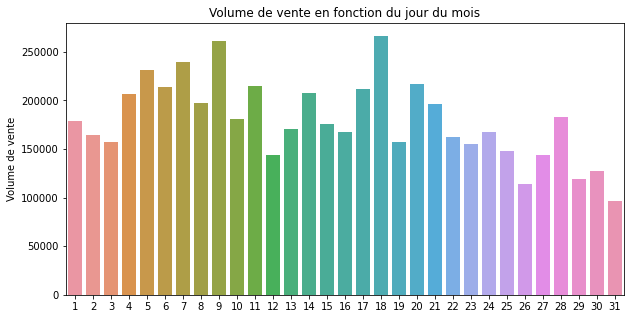

In [ ]:
#Représentation de la quantité en fonction du jour du mois
vis =df_sale[['Quantity','Day']].groupby('Day').sum().reset_index()
sns.barplot(x='Day',y='Quantity', data=vis).set(title='Volume de vente en fonction du jour du mois');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de vente')
fig =plt.gcf()
fig.set_size_inches(10,5)

# on remarque une saisonalité --> tendance à la baisse
# --> moins de ventes en début du mois et beaucoup moins de ventes à la fin du mois
#le volume de vente semble avoir un lien avec le jour du mois


In [ ]:
# Etude de la relation statistique entre Quantity et Day (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Day', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est > à 5% 
#On ne rejette pas l'hypothèse d'indépendance

# conclusion : Quantity ne dépend pas du jour d'achat du mois

,df,sum_sq,mean_sq,F,PR(>F)
Day,1.0,9.558963e+03,9558.962898,0.393652,0.530386
Residual,527791.0,1.281624e+10,24282.788859,NaN,NaN


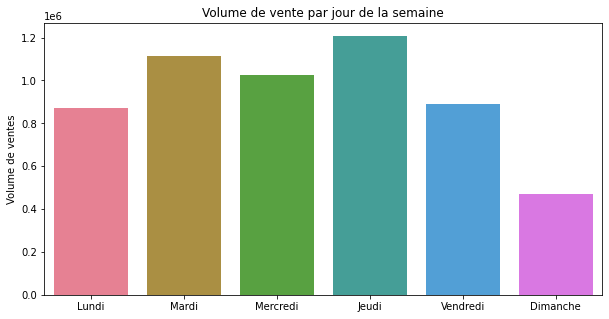

In [ ]:
#Représentation de la quantité en fonction du jour de la semaine
vis =df_sale[['Quantity','DayOfWeek']].groupby('DayOfWeek').sum().reset_index()
sns.barplot(x='DayOfWeek',y='Quantity',  palette='husl',data=vis).set(title='Volume de vente par jour de la semaine');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
axes.xaxis.set_ticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Dimanche']);
fig =plt.gcf()
fig.set_size_inches(10,5)

#On observe qu'il n'y a pas de ventes le Samedi
#Les jeudi et mardi sont les jours comptant le plus de vente.
#Le dimanche est le jour comptabilisant le moins de ventes.

#le volume de vente semble avoir un lien avec le jour de la semaine

In [ ]:
# Etude de la relation statistique entre Quantity et DayOfWeek (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ DayOfWeek', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : Quantity dépend du jour d'achat de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,9.899273e+04,98992.726303,4.076691,0.043479
Residual,527791.0,1.281615e+10,24282.619410,NaN,NaN


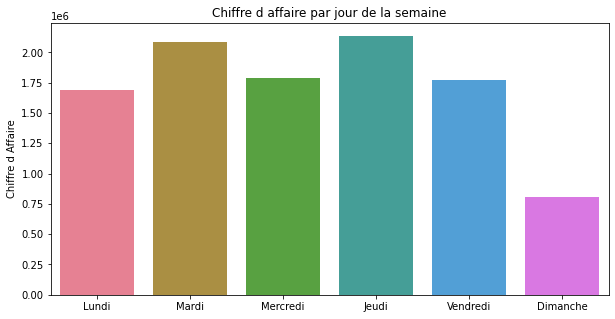

In [ ]:
# Représentation du chiffre d'affaire par jour de la semaine
vis =df_sale[['TotalAmount','DayOfWeek']].groupby('DayOfWeek').sum().reset_index()
sns.barplot(x='DayOfWeek',y='TotalAmount', palette='husl', data=vis).set(title='Chiffre d affaire par jour de la semaine');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Chiffre d Affaire')
axes.xaxis.set_ticklabels(['Lundi','Mardi','Mercredi','Jeudi','Vendredi','Dimanche']);
fig =plt.gcf()
fig.set_size_inches(10,5)

# aucune données le samedi 
# chiffre d'affaire beaucoup plus faible le dimanche.
# et plus élevé le mardi et jeudi.
# Ce qui s'explique par la hausse des ventes le mardi et jeudi et la baisse le dimanche


In [ ]:
# Etude de la relation statistique entre Quantity et InvoiceDay (test de l'anova)
result = statsmodels.formula.api.ols('TotalAmount ~ DayOfWeek', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est > à 5% 
#On ne rejette pas l'hypothèse d'indépendance

# conclusion : TotalAmount ne dépend pas du jour d'achat de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,4.752431e+05,475243.089666,3.303001,0.069154
Residual,540453.0,7.776157e+10,143882.210172,NaN,NaN


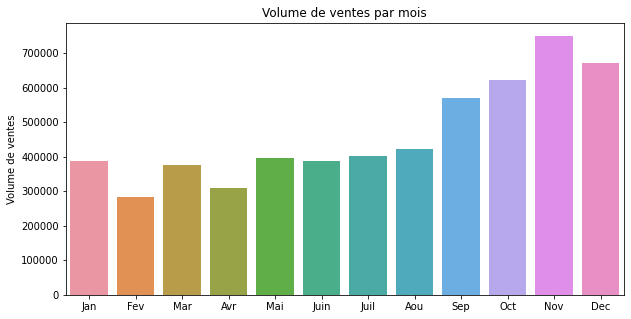

In [ ]:
# Représentation du volume de vente par mois
vis =df_sale[['Quantity','Month']].groupby('Month').sum().reset_index()
sns.barplot(x='Month',y='Quantity', data=vis).set(title='Volume de ventes par mois');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
axes.xaxis.set_ticklabels(['Jan','Fev','Mar','Avr','Mai','Juin','Juil','Aou','Sep','Oct','Nov','Dec']);
fig =plt.gcf()
fig.set_size_inches(10,5)

# Hausse des ventes à partir de septembre. Les ventes atteignent un pic en novembre (période de fêtes)
#La quantité semble dépendre du mois de l'année

In [ ]:
#test stat
# Etude de la relation statistique entre Quantity et Month (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Month', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est > à 5% 
#On ne rejette pas l'hypothèse d'indépendance

# conclusion : Quantity ne dépend pas du mois d'achat

,df,sum_sq,mean_sq,F,PR(>F)
Month,1.0,7.659983e+04,76599.831932,3.154507,0.075718
Residual,527791.0,1.281617e+10,24282.661838,NaN,NaN


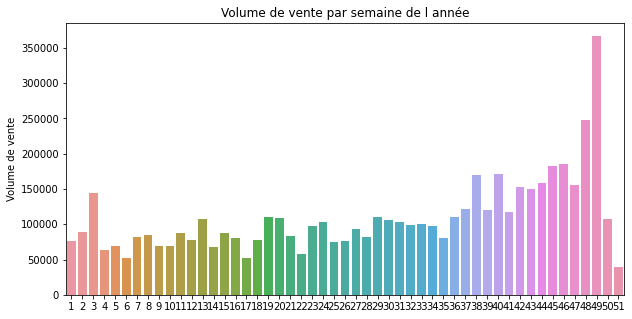

In [ ]:
#représentation du volume de ventes par semaine
volume_par_semaine = df_sale[['Quantity','Week']].groupby('Week').sum().reset_index()
sns.barplot(x='Week',y='Quantity', data=volume_par_semaine).set(title='Volume de vente par semaine de l année');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de vente')
fig =plt.gcf()
fig.set_size_inches(10,5)

# hausse des ventes à la fin de l'année (période des fêtes)
# Il semble y avoir un lien de dépendance entre la quantité et la semaine de l'année

In [ ]:
# Etude de la relation statistique entre Quantity et Week (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Week', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value > à 5% 
#On ne rejette pas l'hypothèse d'indépendance
# conclusion : Quantity ne dépend pas de la semaine de l'année

,df,sum_sq,mean_sq,F,PR(>F)
Week,1.0,7.893044e+04,78930.436341,3.250486,0.071403
Residual,527791.0,1.281617e+10,24282.657422,NaN,NaN


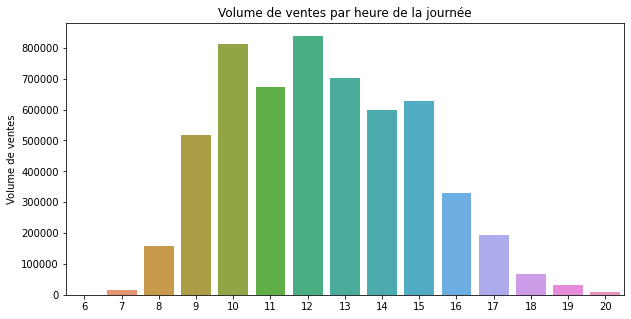

In [ ]:
#y a-t-il un lien de dépendance entre Quantity et Hour ? 
volume_par_heure = df_sale[['Quantity','Hour']].groupby('Hour').sum().reset_index()

sns.barplot(x='Hour',y='Quantity', data=volume_par_heure).set(title='Volume de ventes par heure de la journée');
axes = plt.gca()
axes.set_xlabel('')
axes.set_ylabel('Volume de ventes')
fig =plt.gcf()
fig.set_size_inches(10,5)
# la quantité semble dépendre de l'heure de la transaction

In [ ]:
# les heures de ventes 
df_sale.Hour.unique()

array([ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17,  7, 18, 19, 20,  6])

In [ ]:
''' les ventes ont lieu uniquement de 6h à 20h 
---> hypothèse : correspond à des horaires de bureau 
Il semble y avoir un lien entre quantity et Hour '''

In [ ]:
# Etude de la relation statistique entre Quantity et Hour (test de l'anova)
result = statsmodels.formula.api.ols('Quantity ~ Hour', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value < à 5% 
#On rejette l'hypothèse d'indépendance
# conclusion : Quantity dépend de l'heure de transaction

,df,sum_sq,mean_sq,F,PR(>F)
Hour,1.0,4.594808e+06,4.594808e+06,189.288496,4.624717e-43
Residual,527791.0,1.281165e+10,2.427410e+04,NaN,NaN


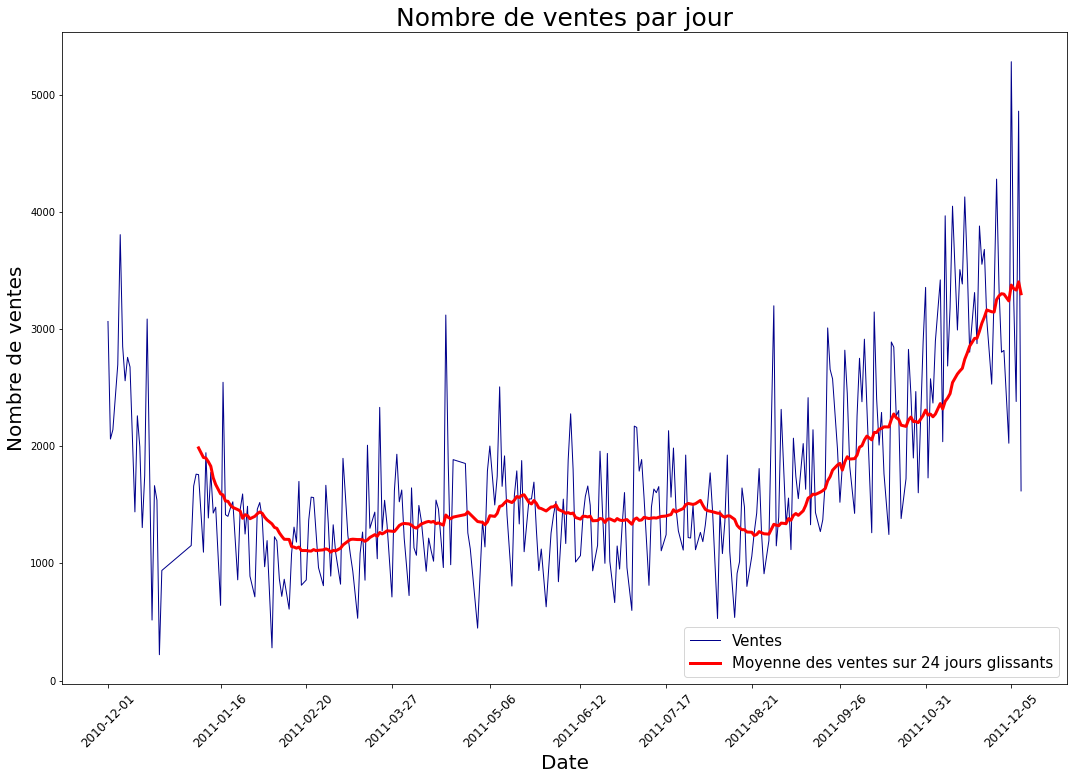

In [ ]:
#Historique de vente sur toute la période par jour
vis =df_sale[['InvoiceNo','Date']].groupby('Date').count().reset_index()
plt.plot(vis['Date'], vis['InvoiceNo'], label ='Ventes', linewidth = 1, color = 'darkblue')

#Moyenne sur 24 jours glissants (1 mois = +-24 jours ouvrables, ici ventes le dimanche mais pas le samedi donc on compte 6 jours par semaine)
plt.plot(vis['Date'], vis[['Date','InvoiceNo']].rolling(24).mean(),linewidth=3, color='red', label ='Moyenne des ventes sur 24 jours glissants')
plt.legend(loc='lower right', fontsize=15)
plt.xlabel('Date',fontsize=20)
plt.ylabel('Nombre de ventes', fontsize=20)
plt.title('Nombre de ventes par jour', fontsize=25)
plt.xticks(vis['Date'][::30],fontsize=12, rotation = 45)
fig =plt.gcf()
fig.set_size_inches(18,12)

#La moyenne de vente augmente avec les années (décembre 2010 est moins performant que décembre 2011), hypothèse d'une entreprise en progression
#On observe de nouveau au pic sur le dernier trimestre de l'année
#La moyenne des ventes des 3 premiers trimestres ne semble pas montrer de fortes évolutions

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



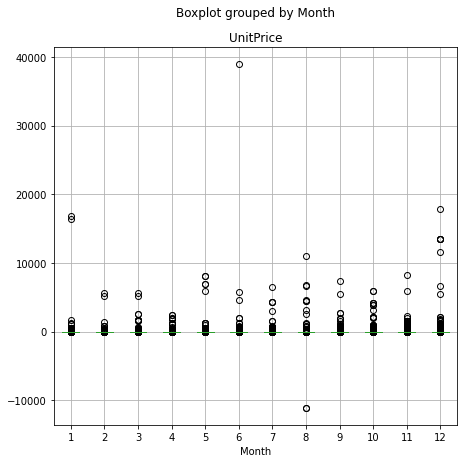

In [ ]:
## Prix unitaire des produits commandés par mois
# boxplot qui affiche UnitPrice groupé par InvoiceMonth

df.boxplot(column='UnitPrice', by='Month', figsize=(7, 7));

# L'objectif est d'analyser visuellement si il existe une saisonnalité des prix des produits commandés. 
#(par exemple, si en été, les clients commandent des produits plus cher qu'en hiver, etc..
# Ainsi, nous pouvons observer une forme de régularité dans les prix des produits commandés tout au long de l'année

In [ ]:
# Etude de la relation statistique entre UnitPrice et Month (test de l'anova)
result = statsmodels.formula.api.ols('UnitPrice ~ Month', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : UnitPrice dépend du mois d'achat
# cela est peut-être dû aux valeurs très éloignées pour le 6ème mois et le 8ème mois 

,df,sum_sq,mean_sq,F,PR(>F)
Month,1.0,1.938158e+03,1938.157621,101.009588,9.199145e-24
Residual,527791.0,1.012718e+07,19.187858,NaN,NaN


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



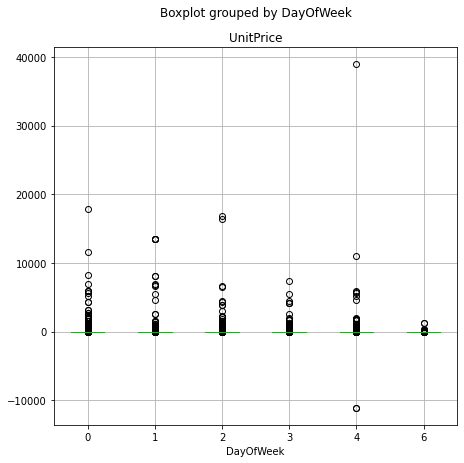

In [ ]:
## Prix unitaire des produits commandé selon le jour de la semaine
# boxplot qui affiche UnitPrice groupé par InvoiceDay

df.boxplot(column='UnitPrice', by='DayOfWeek', figsize=(7, 7));

# On peut observer qu'en semaine, et particulièrement le lundi, les clients commandent 
# des produits avec un prix unitaire élevé, relativement aux autres 
# jours de la semaine et particulièrement le dimanche
# il semblerait y avoir un lien entre le prix et le jour d'achat

In [ ]:
# Etude de la relation statistique entre UnitPrice et DayOfWeek (test de l'anova)
result = statsmodels.formula.api.ols('UnitPrice ~ DayOfWeek', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#p-value (PR(>F)) est < à 5% 
#On rejette l'hypothèse d'indépendance

# conclusion : UnitPrice dépend du jour de la semaine

,df,sum_sq,mean_sq,F,PR(>F)
DayOfWeek,1.0,1.092508e+04,10925.084441,569.880603,6.954776e-126
Residual,527791.0,1.011819e+07,19.170830,NaN,NaN


## *Visualisations sur les produits phares*

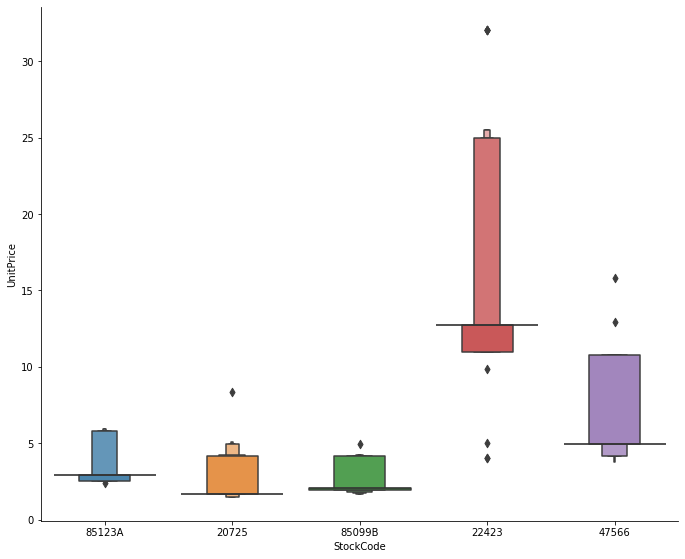

In [ ]:
#TOP 5 des produits les plus vendus (souhaité le pareto pour les 20/80 mais pb de RAM)
codes=["85123A","85099B","22423","47566","20725"]
new =df_sale["StockCode"].isin(codes)
df_sale[new]
sns.catplot(data=df_sale[new], x='StockCode',y='UnitPrice', kind='boxen')
fig =plt.gcf()
fig.set_size_inches(10,8)
#Sur le top produit, les 3 premiers sont vendues en moyenne +-2.5€
#Le 3ème produit est le plus cher du top (+-13€)
#Le 4ème produit à +-6€

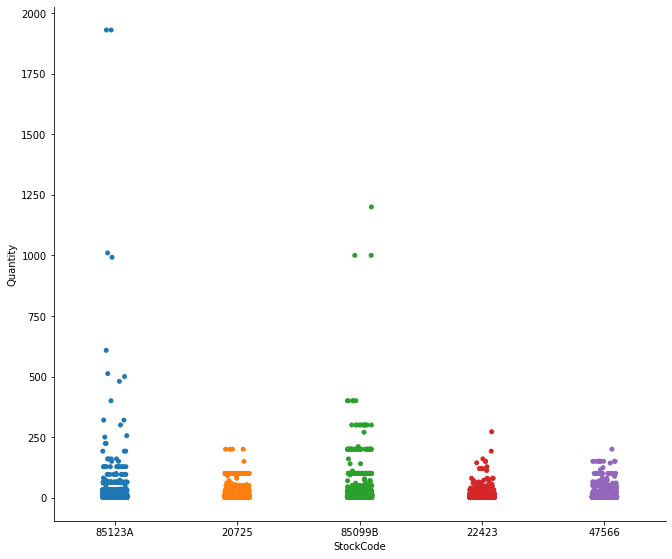

In [ ]:
#Quantité des produits achetés par commandes
sns.catplot(x='StockCode', y='Quantity', data =df_sale[new]);
fig =plt.gcf()
fig.set_size_inches(10,8)
#1er et 3eme produits correspondont à quelques grosse commandes (presque 2000pièces par commandes, ou 1000)
#Pour la majorité des commandes sur ce top produits, les produits sont achetés entre 1 et 200pièces par factures

## *Analyse par pays*

Volume de ventes par pays

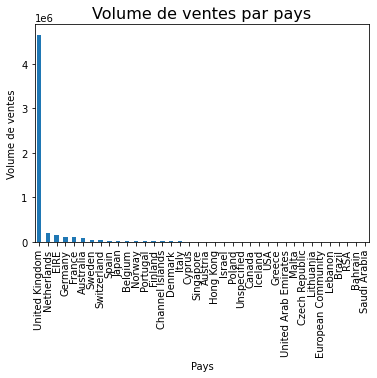

In [ ]:
#Volume de ventes par pays
orders_by_country = df_sale.groupby('Country')['Quantity'].sum().sort_values(ascending=False)

#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Volume de ventes')
plt.title('Volume de ventes par pays', fontsize=16)
plt.show()

#incontestablement, le pays qui concentre le plus d'activité commerciale 
# est le United Kingdom

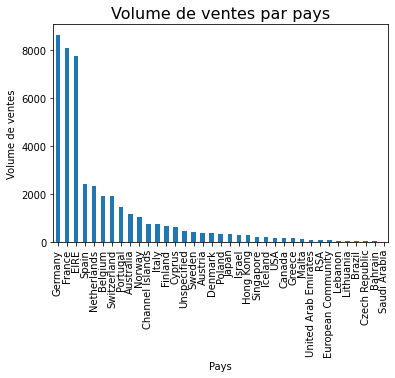

In [ ]:
#Nombre de commandes par Pays - hors United Kingdom
quantity_by_country = df_sale.groupby('Country')['Quantity'].count().sort_values(ascending=False)
del quantity_by_country['United Kingdom']
#Plot
quantity_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Volume de ventes')
plt.title('Volume de ventes par pays', fontsize=16)
plt.show()

# Le pays United Kingdom, est suivi par l'Allemagne, la France

#la quantity semble dépendre du pays d'où provient la commande

In [ ]:
#Analyse de la relation  Quantity & Country
#Pour étudier les relations entre variables quantitatives et qualitatives, on utilise l'analyse de la variance ANOVA

import statsmodels.api 
result = statsmodels.formula.api.ols('Quantity ~ Country', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table

#Si la p-value (PR(>F)) est inférieur à 5% 
#Alors on rejette l'hypothèse selon laquelle Country n'influe pas sur Quantity.

# conclusion : Quantity dépend de Country

,df,sum_sq,mean_sq,F,PR(>F)
Country,37.0,2.296419e+07,620653.869812,25.603529,1.324953e-174
Residual,527755.0,1.279328e+10,24240.950404,NaN,NaN


Nombre de commandes par pays

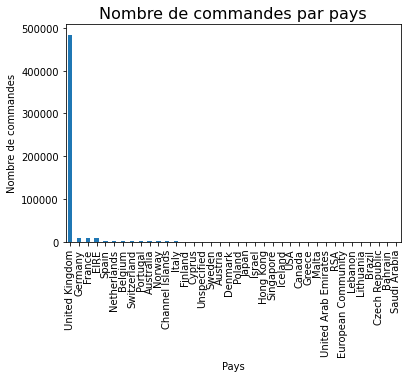

In [ ]:
#nombre de commandes par pays
orders_by_country = df_sale.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)

#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par pays', fontsize=16)
plt.show()

#incontestablement, le pays qui concentre le plus d'activité commerciale 
# est le United Kingdom

Nombre de commandes par Pays - hors UK

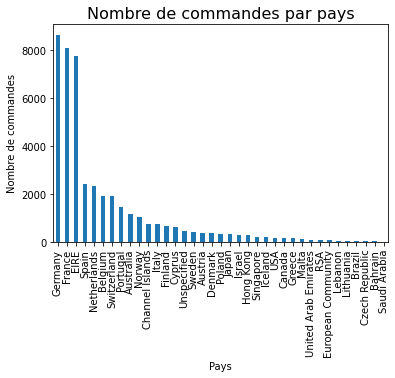

In [ ]:
#Nombre de commandes par Pays - hors United Kingdom
orders_by_country = df_sale.groupby('Country')['InvoiceNo'].count().sort_values(ascending=False)
del orders_by_country['United Kingdom']
#Plot
orders_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Nombre de commandes')
plt.title('Nombre de commandes par pays', fontsize=16)
plt.show()

# Le pays United Kingdom, est suivi par l'Allemagne, la France


Montant moyen dépensé par pays

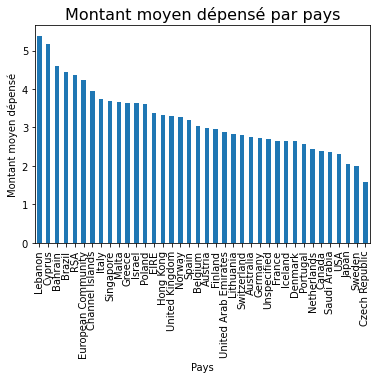

In [ ]:
#Montant moyen dépensé par pays
spend_by_country = df_sale.groupby('Country')['UnitPrice'].mean().sort_values(ascending=False)
#Plot
spend_by_country.plot(kind = 'bar')
plt.xlabel('Pays')
plt.ylabel('Montant moyen dépensé')
plt.title('Montant moyen dépensé par pays', fontsize=16)
plt.show()

# A Chypre et au Liban, les clients passent les commandes les plus importantes en 
# terme de tarif dépensé, suivi du Bahrein 



In [ ]:
#relation entre les variables country et unitprice
result = statsmodels.formula.api.ols('UnitPrice ~ Country', data = df_sale).fit()
table = statsmodels.api.stats.anova_lm(result)

table
#p-value < 5%, on rejette l'hypothèse d'indépendance entre country et unitprice
# conclusion : country dépend de unitprice

,df,sum_sq,mean_sq,F,PR(>F)
Country,37.0,1.448828e+04,391.575080,20.431369,7.991479e-135
Residual,527755.0,1.011463e+07,19.165387,NaN,NaN


# **Modélisations - Time Series**

## *1) Preprocessing - Stationariser et déterminer les paramètres*


In [ ]:
#On repart de nos données quantity agrégées par jour
df_daily = df_sale.groupby(by=['Date'])['Quantity'].sum().reset_index()
df_daily.head()

,Date,Quantity
0,2010-12-01,26909
1,2010-12-02,31327
2,2010-12-03,16177
3,2010-12-05,16371
4,2010-12-06,21768


In [ ]:
#conversion de la date en format date
df_daily['Date'] = pd.to_datetime(df_daily['Date'])

In [ ]:
#on place la date en index
df_daily.index=df_daily.Date
df_daily=df_daily.drop(['Date'], axis=1)

In [ ]:
#on enregistre df_daily sous forme de série
df_daily = pd.Series(data=df_daily['Quantity'])
df_daily

Date
2010-12-01    26909
2010-12-02    31327
2010-12-03    16177
2010-12-05    16371
2010-12-06    21768
              ...  
2011-12-05    43755
2011-12-06    30437
2011-12-07    41857
2011-12-08    35066
2011-12-09    93968
Name: Quantity, Length: 305, dtype: int64

In [ ]:
#ou bien on fait 
#df_daily.to_csv('df_daily.csv')
#df_daily = pd.read_csv('', header=0, parse_dates=[0], index_col=0, squeeze=True)
#df_daily.head()

Date
2010-12-01    26909
2010-12-02    31327
2010-12-03    16177
2010-12-05    16371
2010-12-06    21768
Name: Quantity, dtype: int64

In [ ]:
#on vérifie que la série est bien indexées par les dates
print(df_daily.index)

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-05',
               '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09',
               '2010-12-10', '2010-12-12',
               ...
               '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', name='Date', length=305, freq=None)


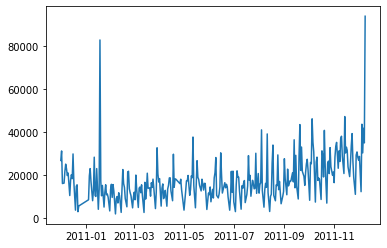

In [ ]:
#représentation graphique de la série temporelle
plt.plot(df_daily);

In [ ]:
''' tout d'abord, nous devons nous assurer que la série est stationaire. 
Dans le cas où cette condition n'est pas vérifiée, nous devons la rendre stationnaire '''

In [ ]:
#test de stationarité 
import statsmodels.api as sm
sm.tsa.stattools.adfuller(df_daily)

(-0.9926909110153154,
 0.7559207795885786,
 5,
 299,
 {'1%': -3.4524113009049935,
  '10%': -2.571946570731871,
  '5%': -2.8712554127251764},
 6068.019265838479)

In [ ]:
''' On obtient une p-valeur largement supérieur à 5%. 
On ne rejette pas l'hypothèse HO. La serie est non stationnaire. 
--> il faut la stationariser '''

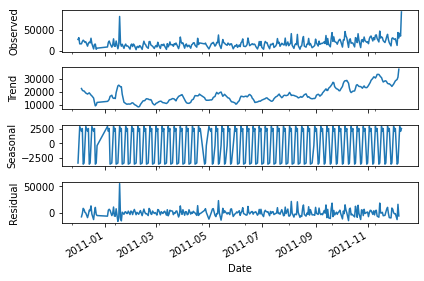

In [ ]:
#décomposition de la série temporelle
from statsmodels.tsa.seasonal import seasonal_decompose
res = seasonal_decompose(df_daily, freq=6)
res.plot()
plt.show()
#nous observons une tendance à la hausse : nous avons un modele multiplicatif et non additif

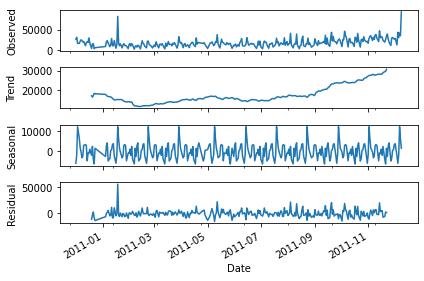

In [ ]:
#décomposition de la série temporelle avec freq = 30
res = seasonal_decompose(df_daily, freq=30)
res.plot()
plt.show()
#nous observons une tendance à la hausse : nous avons un modele multiplicatif et non additif

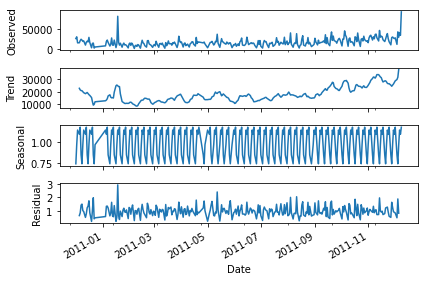

In [ ]:
#décomposition multiplicative de la série temporelle
res = seasonal_decompose(df_daily, model = 'multiplicative', freq=6)
res.plot()
plt.show()

In [ ]:
''' Commençons par utiliser la transormation en  log
  afin de nous ramener à un modèle additif '''

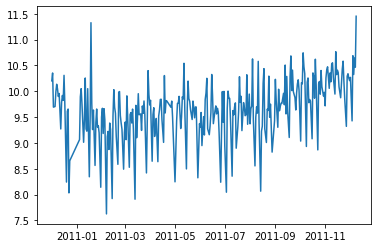

In [ ]:
df_dailylog = np.log(df_daily)
plt.plot(df_dailylog);

In [ ]:
'''La première étape d'une prévision à l'aide des modèles SARIMA est de stationnariser notre série temporelle, 
autrement dit, nous devons estimer les paramètres D et d de notre modèle SARIMA(p,d,q)(P,D,Q)s

On se sert des autocorrélatioons simples. Quel que soit le type de processus, si
 l'autocorrélation simple décroît assez rapidement vers 0 --> le processus est stationnaire.'''

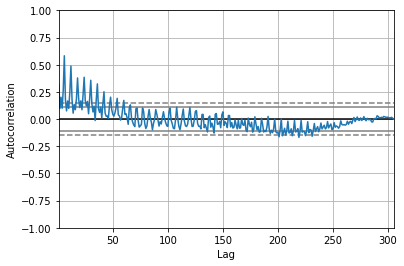

In [ ]:
pd.plotting.autocorrelation_plot(df_dailylog)

In [ ]:
''' La décroissance de la fonction d'autocorrélation est plutôt lente. 
On applique donc une différenciation d'ordre 1 sur notre série temporelle afin de voir si cela 
nous permet de la stationnariser. '''

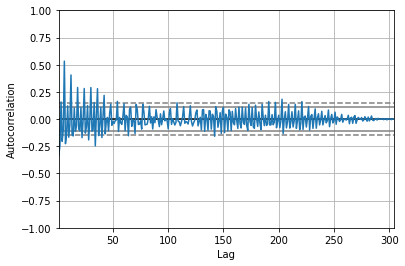

In [ ]:
df_dailylog_1 = df_dailylog.diff().dropna()
pd.plotting.autocorrelation_plot(df_dailylog_1)

In [ ]:
''' L'autocorrélation simple semble tendre vers 0 mais présente des pics saisonniers importants.
Il faut donc éliminer cette saisonnalité.
Nous avons supposé que la série temporelle comportait 
une saisonnalité de période 6 et cette hypothèse semble se confirmer au vu de la fréquence des pics. 
Nous appliquons donc une différenciation de valeur 6
'''

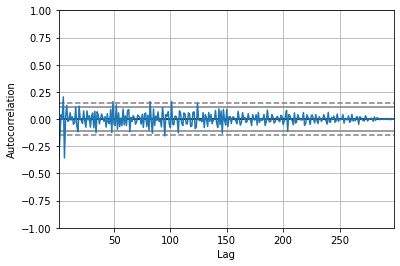

In [ ]:
df_dailylog_2 = df_dailylog_1.diff(periods = 6).dropna()
pd.plotting.autocorrelation_plot(df_dailylog_2);

In [ ]:
''' On arrive ici à un résultat assez satisfaisant malgré les quelques pics irréguliers,
 on peut dire que les valeurs décroissent suffisamment rapidement pour qu'on puisse considérer le processus 
 comme probablement stationnaire.
  On peut donc considérer que l'on a ici un estimateur de l'autocorrélogramme simple de notre processus 
Vérifions que la série est stationnaire '''

In [ ]:
# test de stationarité 
sm.tsa.stattools.adfuller(df_dailylog_2)

(-7.558451277872986,
 3.054932749042278e-11,
 14,
 283,
 {'1%': -3.453670163592738,
  '10%': -2.5722411158835796,
  '5%': -2.8718077069772248},
 379.9731878037207)

In [ ]:
''' on obtient une p-valeur très proche de 0 (donc < 5%) On peut rejeter l'hypothèse HO au seuil de 5%
--> Nous avons bien stationnarisé la série '''

In [ ]:
''' On a différencié une fois à l'ordre 1 et 1 fois à l'ordre 6 (car saisonalité de 6)
--> On a donc d=D=1
--> On a k=6 car saisonnalité de 6

Il nous reste à chercher les paramètres P,Q,p et q
  pour ainsi avoir un processus SARIMA qui pourrait modéliser au mieux notre série temporelle. 
  Pour cela, nous utiliserons les autocorrélogrammes simples et partiels '''

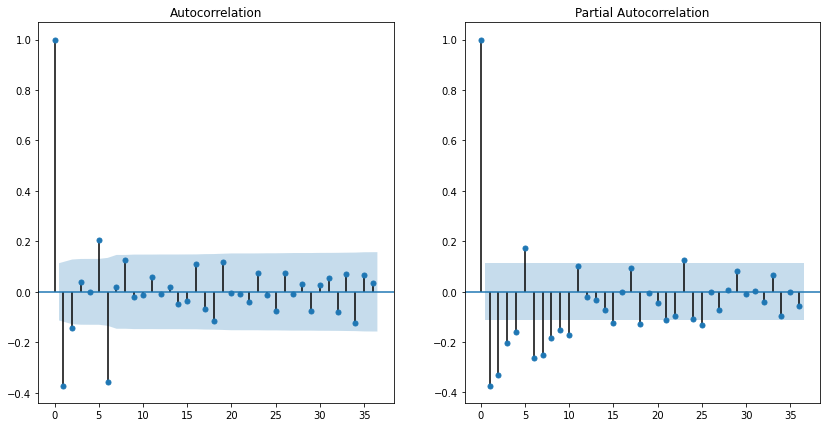

In [ ]:
plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(df_dailylog_2, lags = 36, ax=plt.gca())
plt.subplot(122)
plot_pacf(df_dailylog_2, lags = 36, ax=plt.gca())
plt.show()


In [ ]:
''' La zone bleutée représente la zone de non significativité des autocorrélogrammes. 
Les autocorrélogrammes simple et partiel s'annulent à partir du rang 2.
On a p=q=2-1=1 
Concernant la saisonalité, on distingue un petit pic pour chaque autocorrélogramme au rang 6,
puis rien de significatif aux rangs supérieurs. Les paramètres p,q,P et Q prendront donc tous initialement la valeur 1.
'''

## *2) Modèle ARIMA*

In [ ]:
# Représentation de la série temporelle
# 0 correspond au premier jour dans notre table, 1 au deuxième jour, etc...
fig = go.Figure(data=[go.Scatter(y=df_daily)])
fig.update_layout(xaxis_title="Date",yaxis_title="Volume de vente",title='Série temporelle',height=400,template='ggplot2')
fig.show()

In [ ]:
''' dans un premier temps, on fais un modèle ARIMA avec la transformation log

In [ ]:
# Train & Test Split 
series_date=df_dailylog
split_time = 250
time_d=np.arange(len(df_dailylog))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: ARIMA Model
a_model = ARIMA(endog=train_d , order=(1, 1, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                             ARIMA Model Results                              
Dep. Variable:             D.Quantity   No. Observations:                  249
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -197.563
Method:                       css-mle   S.D. of innovations              0.533
Date:                Wed, 26 May 2021   AIC                            403.126
Time:                        13:43:30   BIC                            417.195
Sample:                             1   HQIC                           408.789
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0013      0.002      0.623      0.534      -0.003       0.005
ar.L1.D.Quantity     0.1321      0.068      1.936      0.054      -0.002       0.266
ma.L1.D.Quantity    -0.9505 

In [ ]:
#definition d'une fonction pour générer un graphique avec les données et leurs prédictions
def plot_(t_train,t_test,x_train,x_test,x_train_pred,x_test_pred,forecast,title):
    xt = (max(t_test)+np.arange(len(forecast)))+1
    fig_train=go.Scatter(name='Train : Actuel ',x=t_train,y=x_train,showlegend=True)
    fig_trian_pred=go.Scatter(name='Train : Prédiction',x=t_train,y=x_train_pred,showlegend=True)
    fig_test=go.Scatter(name='Test : Actuel',x=t_test,y=x_test,showlegend=True)
    fig_test_pred=go.Scatter(name='Test : Prédiction',x=t_test,y=x_test_pred,showlegend=True)
    fig_forecast=go.Scatter(name='Prévision',x=xt,y=forecast,showlegend=True)

    fig = go.Figure([fig_train,fig_trian_pred,fig_test,fig_test_pred,fig_forecast])
    fig.update_layout(xaxis_title='Date',yaxis_title="Volume de ventes",title=title 
                      ,height=400,hovermode="x",template='ggplot2')
    fig.show()

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 9.55886550614974
MSE Test : nan


In [ ]:
''' Nous obtenons quelque chose d'étrange, le modèle ne prédit pas du tout correctement les données
cela est dû au paramètre d. nous devons le paramétrer à 0 '''

In [ ]:
a_model = ARIMA(endog=train_d , order=(1, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 1)   Log Likelihood                -195.675
Method:                       css-mle   S.D. of innovations              0.529
Date:                Wed, 26 May 2021   AIC                            399.351
Time:                        13:45:03   BIC                            413.436
Sample:                             0   HQIC                           405.020
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.5521      0.040    237.152      0.000       9.473       9.631
ar.L1.Quantity    -0.3110      0.130     -2.395      0.017      -0.565      -0.057
ma.L1.Quantity     0.5786      0.104

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#représentation des données et de leurs prédictions 
# en gardant d'abord la transformation log
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes (en valeurs log) - Modèle ARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 0.5293176497718692
MSE Test : nan


In [ ]:
''' Là, nous obtenons bien des prédictions plutôt correctes '''

In [ ]:
#représentation des données et de leurs prédictions 
# en prenant l'exponentiel pour revenir aux données initiales
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = np.exp(train_d),x_test = np.exp(test_d),
      x_train_pred = np.exp(train_pred)
      ,x_test_pred = np.exp(test_pred),forecast = forecast,title='Prévisions des ventes (valeurs initiales) - Modèle ARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 0.5293176497718692
MSE Test : nan


In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

test_d_true = np.array(np.exp(test_d))
test_pred_true = np.array(np.exp(test_pred))

MAPE = np.mean(np.abs((test_d_true - test_pred_true) / test_d_true)) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

#on trouve un taux d'erreur de 49%

Mean Average Prediction Error : 49.03%


In [ ]:
''' Essayons maintenant un modèle ARIMA sans la transformation log'''

In [ ]:
# Train & Test Split 
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
#Modèle ARIMA
a_model = ARIMA(endog=train_d , order=(1, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 1)   Log Likelihood               -2617.490
Method:                       css-mle   S.D. of innovations           8526.095
Date:                Wed, 26 May 2021   AIC                           5242.979
Time:                        10:16:36   BIC                           5257.065
Sample:                             0   HQIC                          5248.648
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.613e+04    629.874     25.614      0.000    1.49e+04    1.74e+04
ar.L1.Quantity    -0.2866      0.184     -1.556      0.121      -0.648       0.074
ma.L1.Quantity     0.5035      0.162

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#paramètre p non significatif --> on l'enlève
a_model = ARIMA(endog=train_d , order=(0, 0, 1))
a_model_fit=a_model.fit()
print(a_model_fit.summary())
#on se retrouve finalement avec un modèle MA

                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(0, 1)   Log Likelihood               -2618.293
Method:                       css-mle   S.D. of innovations           8553.747
Date:                Wed, 26 May 2021   AIC                           5242.586
Time:                        13:47:50   BIC                           5253.150
Sample:                             0   HQIC                          5246.838
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.615e+04    664.729     24.297      0.000    1.48e+04    1.75e+04
ma.L1.Quantity     0.2296      0.068      3.385      0.001       0.097       0.363
                                    

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [ ]:
#représentation des données et de leurs prédictions 
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisons des ventes - Modèle ARIMA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8555.203647800967
MSE Test : nan


In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 44.17%
# On obtient une erreur plus faible 

Mean Average Prediction Error : 44.17%


## *3) Modèle SARIMA*

In [ ]:
 ''' On va maintenant faire un modèle SARIMA
 On a utilisé les séries df_dailylog_1 et df_dailylog_2 uniquement pour déterminer quel degré de différenciation 
 appliquer. On repart bien de notre série non différenciée df_dailylog pour appliquer le modèle SARIMA 
 qui se chargera de faire la différenciation. '''

In [ ]:
# On crée tout d'abord un modèle SARIMA sans spliter les données en échantillons train et test
model=sm.tsa.SARIMAX(df_dailylog,order=(1,1,1),seasonal_order=(1,1,1,6))
results=model.fit()
print(results.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  305
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -180.487
Date:                           Wed, 26 May 2021   AIC                            370.974
Time:                                   10:34:49   BIC                            389.459
Sample:                                        0   HQIC                           378.373
                                           - 305                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1800      0.069      2.618      0.009       0.045       0.315
ma.L1         -0.9669      0.022    -43.515

In [ ]:
''' nous avons uniquement des p-valeurs proches de 0, donc tous les paramètres sont tous significatifs 
Nous devons vérifier que le résidu est un bruit blanc et qu'il est distribué normalement.

Le test de Ljung-Box est un test de blancheur. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0
  : La résidu est un bruit blanc. Ici on lit sur la ligne Prob(Q) que la p-valeur de ce test est de 0.77
 , donc on ne rejette pas l'hypothèse.

Le test de Jarque-Bera est un test de normalité. C'est un test statistique qui vise à rejeter ou non l'hypothèse H0
  : Le résidu suit une distribution normale. Ici on lit sur la ligne Prob (JB) que la p-valeur du test est de 0
 . On rejette donc l'hypothèse.
 donc les résidus ne vérifient pas l'hypothèse de normalité 
 --> le modèle sarima est-il pour autant satisfaisant ? 
 

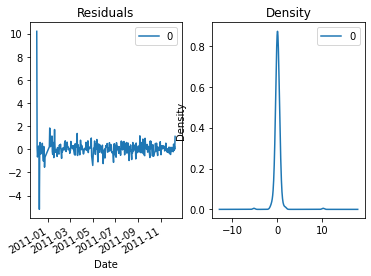

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
''' On va faire un modele en splitant les échantillons train et test

In [ ]:
# Daily: Train & Test Split
series_date=df_dailylog
split_time = 250
time_d=np.arange(len(df_dailylog))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: SARIMAX Model

s_model = sm.tsa.SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -184.361
Date:                           Wed, 26 May 2021   AIC                            380.723
Time:                                   10:36:43   BIC                            401.681
Sample:                                        0   HQIC                           389.165
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -3.186e-07   4.06e-05     -0.008      0.994   -7.98e-05    7.92e-05
ar.L1          0.2510      0.135      1.863

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
''' le paramètre P n'est pas significatif (0.292 > 0.05)--> on le retire '''
s_model = sm.tsa.SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(0, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -181.768
Date:                           Sun, 09 May 2021   AIC                            373.537
Time:                                   14:02:50   BIC                            391.002
Sample:                                        0   HQIC                           380.572
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -8.122e-07   3.03e-05     -0.027      0.979   -6.02e-05    5.86e-05
ar.L1          0.2510      0.137      1.831

In [ ]:
''' le paramètre p n'est pas significatif (0.067 > 0.05) --> on le retire '''
s_model = sm.tsa.SARIMAX(endog=train_d , order=(0, 1, 1), seasonal_order=(0, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 6)   Log Likelihood                -188.584
Date:                           Wed, 26 May 2021   AIC                            385.168
Time:                                   13:48:59   BIC                            399.141
Sample:                                        0   HQIC                           390.796
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       3.639e-06   6.96e-05      0.052      0.958      -0.000       0.000
ma.L1         -0.5664      0.092     -6.171

In [ ]:
''' les paramètres sont significatifs mais les hypothèses sur les résidus ne sont pas vérifiées '''

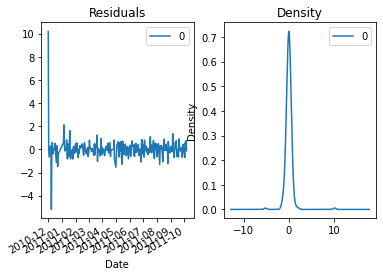

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale

In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
# en gardant le logarithme des données
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

#fonction definie dans la partie 2) Modèle ARIMA
plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes (en valeurs log) - Modèle SARIMA (transforamtion log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
# en supprimant le logarithme des données (donc en prenant l'exponentiel) pour nous ramener aux données initiales

train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = np.exp(train_d),x_test = np.exp(test_d),
      x_train_pred = np.exp(train_pred),x_test_pred = np.exp(test_pred),forecast = np.exp(forecast),
      title='Prévisions des ventes (valeurs initiales) - Modèle SARIMA (transformation log)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''

test_d_true = np.array(np.exp(test_d))
test_pred_true = np.array(np.exp(test_pred))

MAPE = np.mean(np.abs((test_d_true - test_pred_true) / test_d_true)) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

''' l'erreur est abérrante, le modèle n'est pas utilisable '''

Mean Average Prediction Error : 172.63%


In [ ]:
''' Essayons de faire un modèle sans la transformation log

In [ ]:
# Daily: Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
# Daily: SARIMAX Model
s_model = SARIMAX(endog=train_d , order=(1, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -2547.719
Date:                           Mon, 10 May 2021   AIC                           5107.438
Time:                                   12:49:19   BIC                           5128.396
Sample:                                        0   HQIC                          5115.880
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0207      0.031      0.668      0.504      -0.040       0.081
ar.L1          0.1877      0.109      1.723

In [ ]:
# on enlève le paramètre p car non significatif
s_model = SARIMAX(endog=train_d , order=(0, 1, 1), seasonal_order=(1, 1, 1, 6), trend='t')
s_model_fit=s_model.fit()
print(s_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                                 Statespace Model Results                                
Dep. Variable:                          Quantity   No. Observations:                  250
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood               -2550.816
Date:                           Wed, 26 May 2021   AIC                           5111.632
Time:                                   13:50:20   BIC                           5129.098
Sample:                                        0   HQIC                          5118.667
                                           - 250                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          0.0318      0.046      0.689      0.491      -0.059       0.122
ma.L1         -0.9542      0.060    -15.971

In [ ]:
''' les paramètres sont significatifs
l'hypothèse sur les bruits blancs est vérifiée mais la normalité n'est pas vérifiée

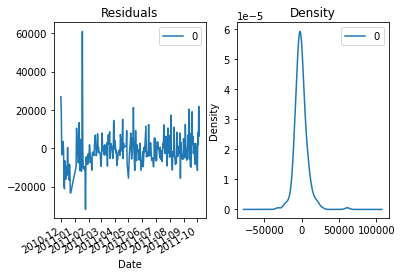

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
# représentation graphique des résultats grâce à la fonction plot_ crée plus tôt
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle SARIMA')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [ ]:
''' Pour terminer, il faut évaluer l'erreur effectuée par le modèle.
 Pour cela, on utilisera la métrique de Mean Average Prediction Error '''


MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Average Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 42.34%

Mean Average Prediction Error : 42.34%


In [ ]:
''' l'erreur de prédiction est 'plus correcte' qu'avec le modele en transformation log.
Peut-être que nous avions finalement un modèle additif ...

Nous pouvons garder ce modèle qui assure tout de même de bonnes prévisions '''

## *4) Modèle Auto-ARIMA*

In [ ]:
''' le but est de trouver les meilleurs paramètres à introduire dans le modèle, 
grâce à la fonction auto_arima du package pmdarima

In [ ]:
# Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
pip install pmdarima as pm

     |████████████████████████████████| 1.5MB 5.1MB/s 
     |████████████████████████████████| 9.5MB 22.9MB/s 
  Created wheel for pm: filename=pm-0.1.1-cp37-none-any.whl size=9285 sha256=376588781d0261f9f8920eae4d88849958a0b9f49171313378eb4448ca04bcb1
  Stored in directory: /root/.cache/pip/wheels/55/e0/0c/7a6356cd6097c4670c6ad74ffcd9b5af47045b73f49917b4df
Successfully built pm
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
#ce code nous permet de trouver des paramètres optimaux pour un modèle ARIMA
# autrement dit, celui qui minimise la métrique AIC
model = auto_arima(train_d, start_p=1, start_q=1,
                      test='adf',       # pour chercher le 'd' optimal
                      max_p=3, max_q=3, # les valeurs maximales testées pour p et q
                      m=1,              # frequence series
                      d=None,           # laisser le modèle determiner 'd'
                      seasonal=False,   # Pas de saisonnalité
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=5245.046, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5620.175, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5348.770, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5503.509, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=5245.200, Time=0.40 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=5244.559, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=5487.663, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=5247.565, Time=0.23 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=5242.758, Time=0.19 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=5469.189, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=5246.723, Time=0.13 sec

Best model:  ARIMA(1,0,3)(0,0,0)[0]          
Total fit time: 2.095 seconds
                           Statespace Model Results                           
Dep. Variable:

In [ ]:
''' --> le meilleur modèle est ARIMA(1,0,3) 
Nous allons représenter les prédictions et calculer le mAPE
'''

In [ ]:
a_model = ARIMA(endog=train_d , order=(1, 0, 3))
a_model_fit=a_model.fit()
print(a_model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                              ARMA Model Results                              
Dep. Variable:               Quantity   No. Observations:                  250
Model:                     ARMA(1, 3)   Log Likelihood               -2611.686
Method:                       css-mle   S.D. of innovations           8320.112
Date:                Wed, 26 May 2021   AIC                           5235.373
Time:                        13:51:01   BIC                           5256.501
Sample:                             0   HQIC                          5243.876
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.757e+04   2398.469      7.325      0.000    1.29e+04    2.23e+04
ar.L1.Quantity     0.9806      0.022     44.530      0.000       0.937       1.024
ma.L1.Quantity    -0.8255      0.067

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = a_model_fit.predict()
test_pred = a_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = a_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle ARIMA (paramètres optimaux)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8328.155546665233
MSE Test : nan


In [ ]:
''' calcul de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Absolute Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 38.21%
#on a trouvé un modèle ARIMA avec une erreur de prédiction plus faible

Mean Absolute Prediction Error : 38.21%


## *5) Modèle Auto-SARIMA*

In [ ]:
''' Le but est de rechercher les meilleurs paramètres pour un modèle SARIMA 
pour ainsi obtenir une erreur de prédiction plus faible '''

In [ ]:
# Train & Test Split
series_date=df_daily
split_time = 250
time_d=np.arange(len(df_daily))
train_d=series_date[:split_time]
test_d=series_date[split_time:]
timeTrain_d = time_d[:split_time]
timeTest_d = time_d[split_time:]
print('Full Set Size ',series_date.shape)
print('Training Set Size ',train_d.shape)
print('Testing Set Size ',test_d.shape)

Full Set Size  (305,)
Training Set Size  (250,)
Testing Set Size  (55,)


In [ ]:
#on utilise la même fonction que précedemment, qui nous permet d'obtenir les meilleurs paramètres 
#pour un modèle SARIMA
#autrement dit, ceux pour lesquels le AIC est minimisé
smodel = auto_arima(train_d, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=6,
                         start_P=0, seasonal=True, #on prend en compte la saisonnalité
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[6] intercept   : AIC=5102.124, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[6] intercept   : AIC=5158.126, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[6] intercept   : AIC=5127.505, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[6] intercept   : AIC=5100.618, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[6]             : AIC=5156.230, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[6] intercept   : AIC=5155.892, Time=0.06 sec
 ARIMA(0,0,1)(1,1,1)[6] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,0,1)(0,1,2)[6] intercept   : AIC=5093.576, Time=0.53 sec
 ARIMA(0,0,1)(1,1,2)[6] intercept   : AIC=5093.676, Time=0.92 sec
 ARIMA(0,0,0)(0,1,2)[6] intercept   : AIC=5096.428, Time=0.40 sec
 ARIMA(1,0,1)(0,1,2)[6] intercept   : AIC=5095.290, Time=0.78 sec
 ARIMA(0,0,2)(0,1,2)[6] intercept   : AIC=5095.319, Time=0.66 sec
 ARIMA(1,0,0)(0,1,2)[6] intercept   : AIC=5093.903, Time=0.56 sec
 ARIMA(1,0,2)(0,1,2)[6] intercept   : AIC=5097.307, Time=1.22 sec
 ARIMA(0,0,1)(0,1,2)[6]             : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  250
Model:             SARIMAX(0, 0, 1)x(0, 1, 2, 6)   Log Likelihood               -2541.788
Date:                           Mon, 10 May 2021   AIC                           5093.576
Time:                                   13:51:11   BIC                           5111.061
Sample:                                        0   HQIC                          5100.618
                                           - 250                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    132.6839    161.736      0.820      0.412    -184.313     449.681
ma.L1          0.1502      0.127      1.182      0.237      -0.099       0.399
ma.S.L6       -0.6472      0.059    -10.885      0.000      -0.764      -0.531
ma.S.L12      -0.2149      0.054     -3.970      0.000      -0.321      -0.109
sigma2      8.626e+07      0.002   5.29e+10      0.000    8.63e+07    8.63e+07
===================================================================================
Ljung-Box (Q):                       17.60   Jarque-Bera (JB):              2691.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             2.35
Prob(H) (two-sided):                  0.12   Kurtosis:                        18.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.99e+25. Standard errors may be unstable.
"""

In [ ]:
''' Le meilleur modèle est SARIMAX(0, 0, 1)x(0, 1, 2, 6)
Etudions ce modèle
'''

In [ ]:
s_model = sm.tsa.SARIMAX(endog=train_d , order=(0, 0, 1), seasonal_order=(0, 1, 2, 6), trend='t')
s_model_fit=s_model.fit()


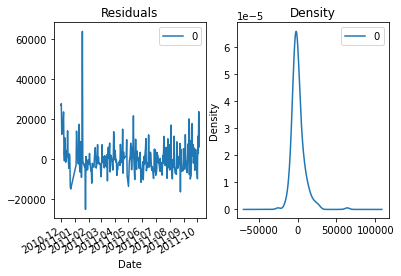

In [ ]:
''' Là encore, l'hypothèse sur les bruits blancs est vérifiée mais pas celle sur la normalité '''
# Plot residual errors
residuals = pd.DataFrame(s_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()
#les résidus semblent tout de même suivre une distribution normale
#nous gardons notre modèle

In [ ]:
#représentation des données avec leurs prédictions apportées par le modèle
train_pred = s_model_fit.predict()
test_pred = s_model_fit.predict(start=min(timeTest_d),end=max(timeTest_d),dynamic=True)

print('MSE Train :',np.sqrt(np.mean((train_pred - train_d)**2)))
print('MSE Test :',np.sqrt(np.mean((test_pred - test_d)**2)))
forecast = s_model_fit.forecast(30, alpha=0.05)
xt = max(timeTest_d)+np.arange(len(forecast))

plot_(t_train = timeTrain_d,t_test = timeTest_d,x_train = train_d,x_test = test_d,x_train_pred = train_pred
      ,x_test_pred = test_pred,forecast = forecast,title='Prévisions des ventes - Modèle SARIMA (paramètres optimaux)')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



MSE Train : 8450.84121104134
MSE Test : nan


In [ ]:
''' calcul de Mean Average Prediction Error '''

MAPE = np.mean(np.abs((np.array(test_d) - np.array(test_pred)) / np.array(test_d))) * 100
print("Mean Absolute Prediction Error : %0.2f%%"% MAPE)

# l'erreur de prédiction est de 29.34%, ce qui est plutôt correct
#on a trouvé un meilleur modèle SARIMA avec une plus faible erreur de prédiction
# C'est le modèle que nous retenons à présent.

Mean Absolute Prediction Error : 29.34%


# **Conclusion**

Après avoir testé plusieurs modèles de régression non satisfaisants, nous obtenons au final d'assez bons modèles de prédictions en utilisant les algorithmes ARIMA et SARIMA.

Notre étude nous a permis d'obtenir un modèle de prévision de vente adapté à nos données et donnant ainsi une erreur de prédiction assez faible de 29%. 
Cette erreur de prédiction aurait pu être améliorée si nous avions un historique plus large dans notre jeu de données (au moins 2 ans). En effet, il existe une saisonnalité d'une année à l'autre, et cela nous aurait permis d'avoir un modèle plus performant.